### Code for deleting files

In [11]:
# import os

# file_path = '/kaggle/working/file_name'

# # Check if the file exists before attempting to remove it
# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"File '{file_path}' has been deleted successfully.")
# else:
#     print(f"File '{file_path}' does not exist.")

### Code for deleting directories & subdirectories & their files

In [7]:
# from pathlib import Path
# import shutil

# TARGET = Path("/kaggle/working/kdef-valence-arousal")  # change if needed

# try:
#     if TARGET.exists() and TARGET.is_dir():
#         # optional extra safety: verify we're deleting under /kaggle/working
#         if "/kaggle/working" in str(TARGET.resolve()):
#             shutil.rmtree(TARGET)
#             print(f"Removed: {TARGET}")
#         else:
#             print("Refusing to remove directory outside /kaggle/working")
#     else:
#         print(f"Path not found or not a directory: {TARGET}")
# except Exception as e:
#     print("Failed to remove directory:", e)

# Balanced RAF-DB dataset

## EfficientNetB3 + CBAM

Device: cuda


/tmp/ipykernel_36/1248307081.py:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/939 [00:00<?, ?it/s]/tmp/ipykernel_36/1248307081.py:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 235/235 [00:32<00:00,  7.27it/s]


Epoch 1/20 | Train Loss: 0.8677, Acc: 60.97% | Val Loss: 0.4331, Acc: 81.38%
Model saved.


Validation: 100%|██████████| 235/235 [00:15<00:00, 15.62it/s]


Epoch 2/20 | Train Loss: 0.2165, Acc: 87.52% | Val Loss: 0.1448, Acc: 90.91%
Model saved.


Validation: 100%|██████████| 235/235 [00:15<00:00, 15.52it/s]


Epoch 3/20 | Train Loss: 0.0994, Acc: 93.60% | Val Loss: 0.1105, Acc: 93.71%
Model saved.


Validation: 100%|██████████| 235/235 [00:15<00:00, 15.58it/s]


Epoch 4/20 | Train Loss: 0.0607, Acc: 95.74% | Val Loss: 0.0905, Acc: 95.22%
Model saved.


Validation: 100%|██████████| 235/235 [00:15<00:00, 15.55it/s]


Epoch 5/20 | Train Loss: 0.0377, Acc: 97.33% | Val Loss: 0.1038, Acc: 95.19%


Validation: 100%|██████████| 235/235 [00:15<00:00, 15.57it/s]


Epoch 6/20 | Train Loss: 0.0266, Acc: 98.07% | Val Loss: 0.1028, Acc: 95.70%


Validation: 100%|██████████| 235/235 [00:15<00:00, 15.56it/s]


Epoch 7/20 | Train Loss: 0.0244, Acc: 98.29% | Val Loss: 0.1028, Acc: 96.22%
Early stopping triggered.


Testing: 100%|██████████| 131/131 [00:18<00:00,  6.90it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.9915    0.9782    0.9848       595
           1     0.9569    0.9697    0.9633       595
           2     0.9933    0.9916    0.9924       595
           3     0.9641    0.9025    0.9323       595
           4     0.8863    0.8908    0.8885       595
           5     0.8873    0.9395    0.9127       595
           6     0.9648    0.9664    0.9656       595

    accuracy                         0.9484      4165
   macro avg     0.9492    0.9484    0.9485      4165
weighted avg     0.9492    0.9484    0.9485      4165



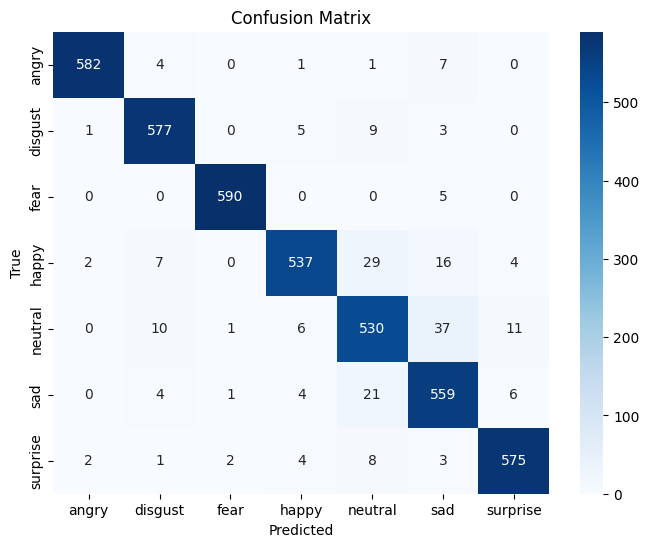

In [6]:
# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/input/balanced-raf-db-dataset-7575-grayscale'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetCBAM(num_classes=7).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 2.0, 2.5, 1.0, 1.2, 1.5, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_cbam_raf_db.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_raf_db.pth"))
test_and_report(model, test_loader)

## MobileNetV3 Student (Knowledge Distillation)

/tmp/ipykernel_36/147147251.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/939 [00:00<?, ?it/s]/tmp/ipykernel_36/147147251.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 235/235 [00:12<00:00, 18.71it/s]


[Student] Epoch 1/30 | Train Loss: 3.8236, Acc: 53.65% | Val Loss: 0.9243, Acc: 68.34%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.31it/s]


[Student] Epoch 2/30 | Train Loss: 2.0514, Acc: 73.64% | Val Loss: 0.6470, Acc: 77.60%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.75it/s]


[Student] Epoch 3/30 | Train Loss: 1.5139, Acc: 80.51% | Val Loss: 0.5447, Acc: 80.90%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.99it/s]


[Student] Epoch 4/30 | Train Loss: 1.2364, Acc: 84.84% | Val Loss: 0.3970, Acc: 85.83%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.97it/s]


[Student] Epoch 5/30 | Train Loss: 1.0513, Acc: 87.57% | Val Loss: 0.3528, Acc: 88.01%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.61it/s]


[Student] Epoch 6/30 | Train Loss: 0.9374, Acc: 89.37% | Val Loss: 0.3091, Acc: 89.14%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.68it/s]


[Student] Epoch 7/30 | Train Loss: 0.8490, Acc: 90.79% | Val Loss: 0.2617, Acc: 90.55%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.46it/s]


[Student] Epoch 8/30 | Train Loss: 0.7799, Acc: 92.06% | Val Loss: 0.2519, Acc: 91.18%
Student model saved.


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.90it/s]


[Student] Epoch 9/30 | Train Loss: 0.7334, Acc: 92.49% | Val Loss: 0.2185, Acc: 92.67%
Student model saved.


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.79it/s]


[Student] Epoch 10/30 | Train Loss: 0.6899, Acc: 93.54% | Val Loss: 0.2353, Acc: 91.75%


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.57it/s]


[Student] Epoch 11/30 | Train Loss: 0.6484, Acc: 94.04% | Val Loss: 0.2050, Acc: 92.90%
Student model saved.


Validation: 100%|██████████| 235/235 [00:19<00:00, 11.91it/s]


[Student] Epoch 12/30 | Train Loss: 0.6184, Acc: 94.54% | Val Loss: 0.1962, Acc: 93.14%
Student model saved.


Validation: 100%|██████████| 235/235 [00:13<00:00, 16.92it/s]


[Student] Epoch 13/30 | Train Loss: 0.5974, Acc: 94.98% | Val Loss: 0.1891, Acc: 93.72%
Student model saved.


Validation: 100%|██████████| 235/235 [00:13<00:00, 17.70it/s]


[Student] Epoch 14/30 | Train Loss: 0.5757, Acc: 95.37% | Val Loss: 0.1747, Acc: 94.34%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.72it/s]


[Student] Epoch 15/30 | Train Loss: 0.5599, Acc: 95.67% | Val Loss: 0.1704, Acc: 94.39%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.14it/s]


[Student] Epoch 16/30 | Train Loss: 0.5360, Acc: 96.06% | Val Loss: 0.1715, Acc: 94.38%


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.62it/s]


[Student] Epoch 17/30 | Train Loss: 0.5244, Acc: 96.09% | Val Loss: 0.1634, Acc: 94.78%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.62it/s]


[Student] Epoch 18/30 | Train Loss: 0.5085, Acc: 96.37% | Val Loss: 0.1591, Acc: 95.00%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.41it/s]


[Student] Epoch 19/30 | Train Loss: 0.4960, Acc: 96.69% | Val Loss: 0.1579, Acc: 95.04%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.64it/s]


[Student] Epoch 20/30 | Train Loss: 0.4895, Acc: 96.77% | Val Loss: 0.1585, Acc: 94.75%


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.69it/s]


[Student] Epoch 21/30 | Train Loss: 0.4743, Acc: 96.92% | Val Loss: 0.1545, Acc: 95.06%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.56it/s]


[Student] Epoch 22/30 | Train Loss: 0.4706, Acc: 96.91% | Val Loss: 0.1534, Acc: 95.26%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.33it/s]


[Student] Epoch 23/30 | Train Loss: 0.4672, Acc: 97.08% | Val Loss: 0.1519, Acc: 95.19%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.77it/s]


[Student] Epoch 24/30 | Train Loss: 0.4541, Acc: 97.18% | Val Loss: 0.1491, Acc: 95.40%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.91it/s]


[Student] Epoch 25/30 | Train Loss: 0.4528, Acc: 97.24% | Val Loss: 0.1490, Acc: 95.40%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.44it/s]


[Student] Epoch 26/30 | Train Loss: 0.4523, Acc: 97.25% | Val Loss: 0.1425, Acc: 95.56%
Student model saved.


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.25it/s]


[Student] Epoch 27/30 | Train Loss: 0.4487, Acc: 97.47% | Val Loss: 0.1475, Acc: 95.20%


Validation: 100%|██████████| 235/235 [00:13<00:00, 18.05it/s]


[Student] Epoch 28/30 | Train Loss: 0.4458, Acc: 97.38% | Val Loss: 0.1453, Acc: 95.60%


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.56it/s]


[Student] Epoch 29/30 | Train Loss: 0.4452, Acc: 97.26% | Val Loss: 0.1464, Acc: 95.56%


Validation: 100%|██████████| 235/235 [00:12<00:00, 18.81it/s]


[Student] Epoch 30/30 | Train Loss: 0.4447, Acc: 97.37% | Val Loss: 0.1435, Acc: 95.55%


Testing: 100%|██████████| 131/131 [00:09<00:00, 13.39it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.9867    0.9966    0.9916       595
           1     0.9602    0.9731    0.9666       595
           2     0.9950    1.0000    0.9975       595
           3     0.9533    0.8924    0.9219       595
           4     0.8844    0.8487    0.8662       595
           5     0.8760    0.9378    0.9058       595
           6     0.9682    0.9731    0.9707       595

    accuracy                         0.9460      4165
   macro avg     0.9463    0.9460    0.9458      4165
weighted avg     0.9463    0.9460    0.9458      4165



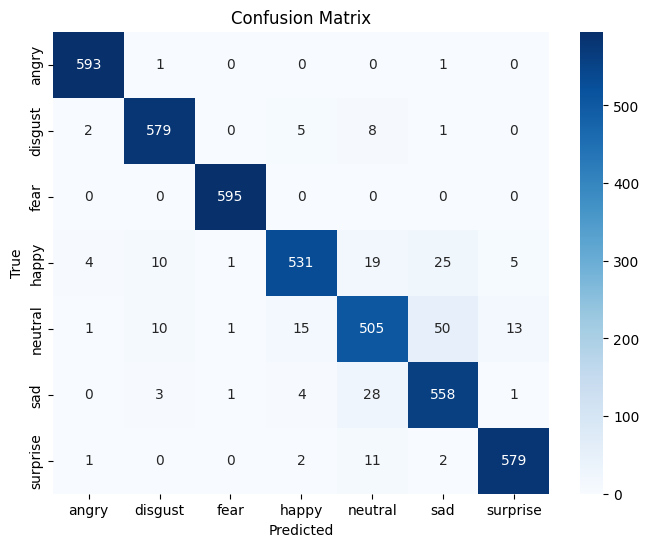

In [7]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Dataset paths for RAF-DB
raf_base_dir = '/kaggle/input/balanced-raf-db-dataset-7575-grayscale'
raf_train_dir = os.path.join(raf_base_dir, 'train')
raf_val_dir = os.path.join(raf_base_dir, 'val')
raf_test_dir = os.path.join(raf_base_dir, 'test')

# Load RAF-DB datasets
raf_train_dataset = datasets.ImageFolder(root=raf_train_dir, transform=default_transform)
raf_val_dataset = datasets.ImageFolder(root=raf_val_dir, transform=default_transform)
raf_test_dataset = datasets.ImageFolder(root=raf_test_dir, transform=default_transform)

# DataLoaders
raf_train_loader = DataLoader(raf_train_dataset, batch_size=32, shuffle=True, num_workers=2)
raf_val_loader = DataLoader(raf_val_dataset, batch_size=32, shuffle=False, num_workers=2)
raf_test_loader = DataLoader(raf_test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model trained on RAF-DB
teacher_model = EfficientNetCBAM(num_classes=7).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_raf_db.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 7)
student_model.num_classes = 7
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            student_outputs = student_logits.view(images.size(0), -1)
            loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.view(images.size(0), -1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=raf_test_dataset.classes,
                yticklabels=raf_test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, raf_train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, raf_val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/mobilenetv3_student_raf_db.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/mobilenetv3_student_raf_db.pth"))
test_and_report(student_model, raf_test_loader)

## Quantization

Testing Quantized: 100%|██████████| 131/131 [00:25<00:00,  5.05it/s]



Quantized Model Report:
              precision    recall  f1-score   support

           0     0.9950    0.9966    0.9958       595
           1     0.9639    0.9866    0.9751       595
           2     0.9933    0.9983    0.9958       595
           3     0.9542    0.9109    0.9321       595
           4     0.8850    0.8924    0.8887       595
           5     0.9150    0.9227    0.9188       595
           6     0.9781    0.9765    0.9773       595

    accuracy                         0.9549      4165
   macro avg     0.9549    0.9549    0.9548      4165
weighted avg     0.9549    0.9549    0.9548      4165



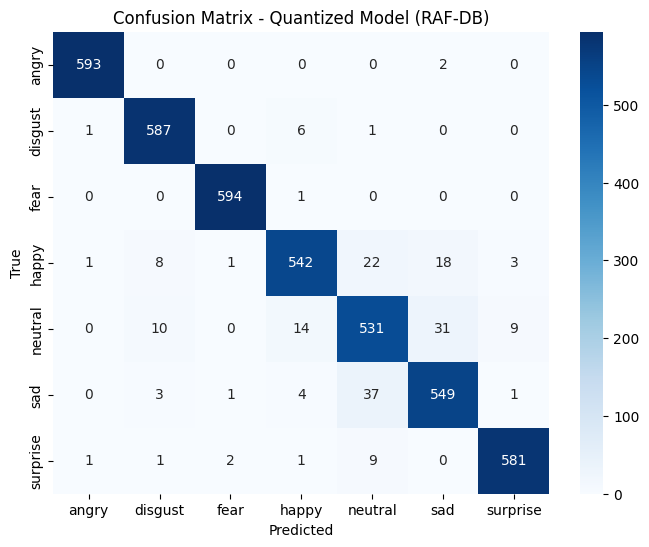

In [8]:
# Dataset paths for RAF-DB
raf_base_dir = '/kaggle/input/balanced-raf-db-dataset-7575-grayscale'
raf_test_dir = os.path.join(raf_base_dir, 'test')

# Simplified transform for inference
inference_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load RAF-DB datasets
raf_test_dataset = datasets.ImageFolder(root=raf_test_dir, transform=inference_transform)

# DataLoaders
raf_test_loader = DataLoader(raf_test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load trained MobileNetV3 Small student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 7)
student_model.num_classes = 7
student_model.load_state_dict(torch.load("/kaggle/working/mobilenetv3_student_raf_db.pth"))
student_model.eval()
student_model.to('cpu')  # Quantization must run on CPU

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Evaluation function
def test_quantized(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Quantized"):
            outputs = model(images.to('cpu'))
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).numpy())
            all_labels.extend(labels.numpy())

    print("\nQuantized Model Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=raf_test_dataset.classes,
                yticklabels=raf_test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Quantized Model (RAF-DB)')
    plt.show()

# Run evaluation
test_quantized(quantized_model, raf_test_loader)
torch.save(quantized_model.state_dict(), "/kaggle/working/mobilenetv3_quantized_raf_db.pth")

## Inference Performance

In [9]:
import os

def get_model_size(path):
    size_mb = os.path.getsize(path) / (1024 * 1024)
    print(f"Model size: {size_mb:.2f} MB")

# Paths to saved models
get_model_size("/kaggle/working/efficientnet_cbam_raf_db.pth")
get_model_size("/kaggle/working/mobilenetv3_student_raf_db.pth")
get_model_size("/kaggle/working/mobilenetv3_quantized_raf_db.pth")

Model size: 42.51 MB
Model size: 5.95 MB
Model size: 4.24 MB


In [11]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params: {total:,} | Trainable: {trainable:,}")

# Load models
teacher = EfficientNetCBAM(num_classes=7)
teacher.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_raf_db.pth", map_location='cpu'))

# Load the quantized model architecture directly
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 7)
student_model.num_classes = 7

# Apply quantization BEFORE loading weights
quantized_student = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Now load the quantized weights
quantized_student.load_state_dict(torch.load("/kaggle/working/mobilenetv3_quantized_raf_db.pth", map_location='cpu'))

count_parameters(teacher)
count_parameters(student)
count_parameters(quantized_student)

Total params: 11,002,001 | Trainable: 11,002,001
Total params: 1,525,031 | Trainable: 1,525,031
Total params: 927,008 | Trainable: 927,008


In [12]:
import time

def measure_inference_time(model, input_tensor, runs=100):
    model.eval()
    with torch.no_grad():
        start = time.time()
        for _ in range(runs):
            _ = model(input_tensor)
        end = time.time()
    avg_time = (end - start) / runs
    print(f"Avg inference time: {avg_time * 1000:.2f} ms")

# Dummy input
dummy_input = torch.randn(1, 3, 224, 224)

# Run on CPU for fair comparison
teacher.to('cpu')
student.to('cpu')
quantized_student.to('cpu')

measure_inference_time(teacher, dummy_input)
measure_inference_time(student, dummy_input)
measure_inference_time(quantized_student, dummy_input)

Avg inference time: 74.05 ms
Avg inference time: 10.47 ms
Avg inference time: 10.82 ms


# RAF-DB Circumplex Model (Quadrant Dataset) -> Valence Arousal

## Dataset Creation by Label Mapping to Quadrant

In [1]:
import os
from shutil import copy2

# Corrected emotion-to-quadrant label mapping
label_map = {
    'angry': 'negative_high',
    'fear': 'negative_high',
    'disgust': 'negative_high',
    'sad': 'negative_low',
    'neutral': 'neutral',
    'happy': 'positive_high',
    'surprise': 'positive_high'
}

# Paths
base_path = '/kaggle/input/balanced-raf-db-dataset-7575-grayscale'
output_path = '/kaggle/working/rafdb-valence-arousal'
splits = ['train', 'val', 'test']

# Create new folder structure
for split in splits:
    for new_label in set(label_map.values()):
        os.makedirs(os.path.join(output_path, split, new_label), exist_ok=True)

# Remap and copy files
skipped_classes = []

for split in splits:
    split_path = os.path.join(base_path, split)
    for original_class in os.listdir(split_path):
        class_key = original_class.lower()
        new_label = label_map.get(class_key)
        if not new_label:
            skipped_classes.append(original_class)
            continue

        original_class_path = os.path.join(split_path, original_class)
        for file in os.listdir(original_class_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(original_class_path, file)
                dst = os.path.join(output_path, split, new_label, file)
                copy2(src, dst)

# Report skipped classes
if skipped_classes:
    print("Skipped classes (no mapping found):", skipped_classes)
else:
    print("All classes successfully remapped.")

All classes successfully remapped.


In [2]:
import os

def count_images_by_class(base_path):
    class_counts = {}
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            if os.path.isdir(cls_path):
                count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                class_counts[f"{split}/{cls}"] = count
    return class_counts

original_counts = count_images_by_class('/kaggle/input/balanced-raf-db-dataset-7575-grayscale')
remapped_counts = count_images_by_class('/kaggle/working/rafdb-valence-arousal')

print("Original Dataset Counts:")
for k, v in original_counts.items():
    print(f"{k}: {v}")

print("\nRemapped Dataset Counts:")
for k, v in remapped_counts.items():
    print(f"{k}: {v}")

Original Dataset Counts:
train/surprise: 4289
train/fear: 4289
train/angry: 4289
train/neutral: 4289
train/sad: 4289
train/disgust: 4289
train/happy: 4289
val/surprise: 1072
val/fear: 1072
val/angry: 1072
val/neutral: 1072
val/sad: 1072
val/disgust: 1072
val/happy: 1072
test/surprise: 595
test/fear: 595
test/angry: 595
test/neutral: 595
test/sad: 595
test/disgust: 595
test/happy: 595

Remapped Dataset Counts:
train/positive_high: 8576
train/neutral: 4289
train/negative_low: 4289
train/negative_high: 12816
val/positive_high: 2144
val/neutral: 1072
val/negative_low: 1072
val/negative_high: 3215
test/positive_high: 1190
test/neutral: 595
test/negative_low: 595
test/negative_high: 1785


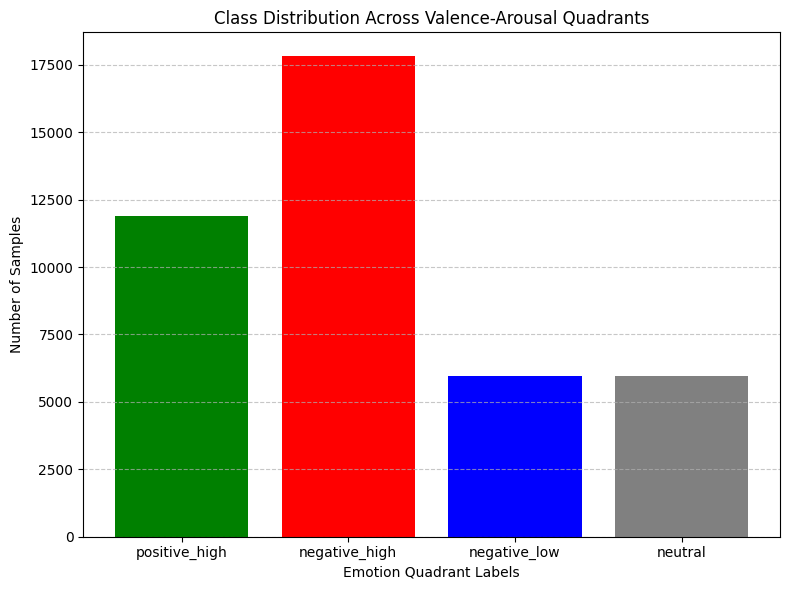

In [3]:
import os
import matplotlib.pyplot as plt

# Path to the dataset
dataset_path = '/kaggle/working/rafdb-valence-arousal'
splits = ['train', 'val', 'test']
labels = ['positive_high', 'negative_high', 'negative_low', 'neutral']

# Count samples per label across all splits
label_counts = {label: 0 for label in labels}

for split in splits:
    for label in labels:
        folder = os.path.join(dataset_path, split, label)
        if os.path.exists(folder):
            count = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
            label_counts[label] += count

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values(), color=['green', 'red', 'blue', 'gray'])
plt.title('Class Distribution Across Valence-Arousal Quadrants')
plt.xlabel('Emotion Quadrant Labels')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## EfficientNetB3 + CBAM -> Valence Arousal RAF-DB

Device: cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/tmp/ipykernel_36/3302079243.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/937 [00:00<?, ?it/s]/tmp/ipykernel_36/3302079243.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 235/235 [00:22<00:00, 10.54it/s]


Epoch 1/20 | Train Loss: 0.4832, Acc: 65.16% | Val Loss: 0.2546, Acc: 81.69%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.50it/s]


Epoch 2/20 | Train Loss: 0.1837, Acc: 86.13% | Val Loss: 0.1223, Acc: 90.46%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.53it/s]


Epoch 3/20 | Train Loss: 0.0838, Acc: 92.98% | Val Loss: 0.0837, Acc: 93.56%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.54it/s]


Epoch 4/20 | Train Loss: 0.0449, Acc: 96.15% | Val Loss: 0.0731, Acc: 95.18%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.55it/s]


Epoch 5/20 | Train Loss: 0.0279, Acc: 97.41% | Val Loss: 0.0703, Acc: 95.82%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.61it/s]


Epoch 6/20 | Train Loss: 0.0205, Acc: 98.13% | Val Loss: 0.0692, Acc: 96.51%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.57it/s]


Epoch 7/20 | Train Loss: 0.0171, Acc: 98.48% | Val Loss: 0.0703, Acc: 96.36%


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.56it/s]


Epoch 8/20 | Train Loss: 0.0136, Acc: 98.80% | Val Loss: 0.0731, Acc: 96.69%


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.53it/s]


Epoch 9/20 | Train Loss: 0.0137, Acc: 98.88% | Val Loss: 0.0585, Acc: 96.84%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.56it/s]


Epoch 10/20 | Train Loss: 0.0114, Acc: 98.91% | Val Loss: 0.0589, Acc: 96.93%


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.57it/s]


Epoch 11/20 | Train Loss: 0.0110, Acc: 99.06% | Val Loss: 0.0593, Acc: 97.33%


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.56it/s]


Epoch 12/20 | Train Loss: 0.0105, Acc: 99.16% | Val Loss: 0.0579, Acc: 97.01%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.58it/s]


Epoch 13/20 | Train Loss: 0.0084, Acc: 99.26% | Val Loss: 0.0520, Acc: 97.47%
Model saved.


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.57it/s]


Epoch 14/20 | Train Loss: 0.0093, Acc: 99.17% | Val Loss: 0.0637, Acc: 97.03%


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.52it/s]


Epoch 15/20 | Train Loss: 0.0072, Acc: 99.35% | Val Loss: 0.0706, Acc: 96.97%


Validation: 100%|██████████| 235/235 [00:22<00:00, 10.54it/s]


Epoch 16/20 | Train Loss: 0.0080, Acc: 99.31% | Val Loss: 0.0549, Acc: 97.05%
Early stopping triggered.


Testing: 100%|██████████| 131/131 [00:12<00:00, 10.50it/s]



Classification Report:
               precision    recall  f1-score   support

negative_high     0.9927    0.9860    0.9893      1785
 negative_low     0.9394    0.9647    0.9519       595
      neutral     0.9129    0.9513    0.9317       595
positive_high     0.9750    0.9513    0.9630      1190

     accuracy                         0.9681      4165
    macro avg     0.9550    0.9633    0.9590      4165
 weighted avg     0.9686    0.9681    0.9682      4165



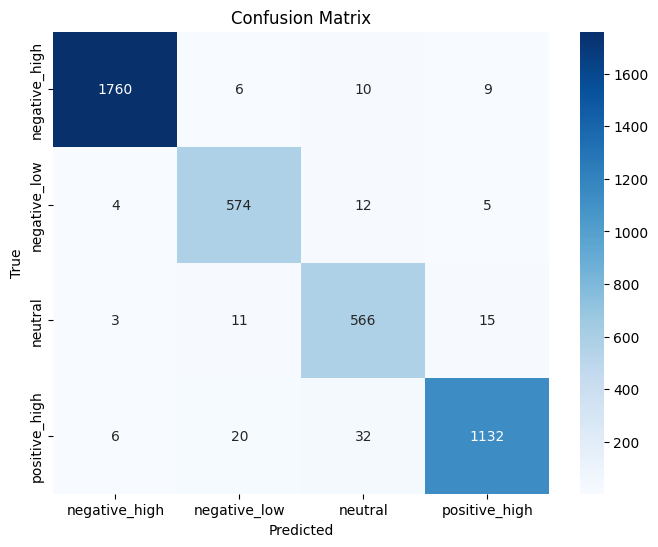

In [2]:
# Reproducibility
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/working/rafdb-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetCBAM(num_classes=4).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 1.5, 1.2, 1.0]).to(device)  # Adjust based on class distribution
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/rafdb_effnet_cbam_valence_arousal.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/rafdb_effnet_cbam_valence_arousal.pth"))
test_and_report(model, test_loader)

## MobileNetV3 Student (Knowledge Distillation) -> Valence Arousal RAF-DB

Device: cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 92.9MB/s]
/tmp/ipykernel_36/1596036855.py:154: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/937 [00:00<?, ?it/s]/tmp/ipykernel_36/1596036855.py:169: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 235/235 [00:11<00:00, 21.14it/s]


[Student] Epoch 1/30 | Train Loss: 4.1191, Acc: 62.20% | Val Loss: 0.7554, Acc: 74.13%
Student model saved.


Validation: 100%|██████████| 235/235 [00:11<00:00, 21.23it/s]


[Student] Epoch 2/30 | Train Loss: 2.5423, Acc: 77.01% | Val Loss: 0.6307, Acc: 80.15%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.06it/s]


[Student] Epoch 3/30 | Train Loss: 1.9598, Acc: 82.66% | Val Loss: 0.5479, Acc: 82.87%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.03it/s]


[Student] Epoch 4/30 | Train Loss: 1.5871, Acc: 86.38% | Val Loss: 0.3497, Acc: 87.86%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.40it/s]


[Student] Epoch 5/30 | Train Loss: 1.3396, Acc: 89.04% | Val Loss: 0.3194, Acc: 89.28%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.90it/s]


[Student] Epoch 6/30 | Train Loss: 1.1721, Acc: 90.98% | Val Loss: 0.3114, Acc: 89.71%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.44it/s]


[Student] Epoch 7/30 | Train Loss: 1.0304, Acc: 92.43% | Val Loss: 0.2642, Acc: 91.03%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.72it/s]


[Student] Epoch 8/30 | Train Loss: 0.9453, Acc: 93.32% | Val Loss: 0.2245, Acc: 92.58%
Student model saved.


Validation: 100%|██████████| 235/235 [00:11<00:00, 21.31it/s]


[Student] Epoch 9/30 | Train Loss: 0.8558, Acc: 94.38% | Val Loss: 0.2662, Acc: 91.79%


Validation: 100%|██████████| 235/235 [00:11<00:00, 21.31it/s]


[Student] Epoch 10/30 | Train Loss: 0.7951, Acc: 95.14% | Val Loss: 0.1904, Acc: 93.79%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.71it/s]


[Student] Epoch 11/30 | Train Loss: 0.7410, Acc: 95.64% | Val Loss: 0.1793, Acc: 94.08%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.40it/s]


[Student] Epoch 12/30 | Train Loss: 0.7015, Acc: 96.20% | Val Loss: 0.1655, Acc: 94.63%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.81it/s]


[Student] Epoch 13/30 | Train Loss: 0.6528, Acc: 96.57% | Val Loss: 0.1614, Acc: 94.75%
Student model saved.


Validation: 100%|██████████| 235/235 [00:11<00:00, 21.19it/s]


[Student] Epoch 14/30 | Train Loss: 0.6256, Acc: 96.93% | Val Loss: 0.1642, Acc: 94.54%


Validation: 100%|██████████| 235/235 [00:11<00:00, 21.24it/s]


[Student] Epoch 15/30 | Train Loss: 0.5932, Acc: 97.17% | Val Loss: 0.1619, Acc: 94.96%


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.43it/s]


[Student] Epoch 16/30 | Train Loss: 0.5604, Acc: 97.52% | Val Loss: 0.1400, Acc: 95.44%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.45it/s]


[Student] Epoch 17/30 | Train Loss: 0.5496, Acc: 97.60% | Val Loss: 0.1388, Acc: 95.72%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.37it/s]


[Student] Epoch 18/30 | Train Loss: 0.5239, Acc: 97.87% | Val Loss: 0.1349, Acc: 95.36%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.15it/s]


[Student] Epoch 19/30 | Train Loss: 0.5098, Acc: 98.01% | Val Loss: 0.1292, Acc: 95.78%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.07it/s]


[Student] Epoch 20/30 | Train Loss: 0.4912, Acc: 98.20% | Val Loss: 0.1281, Acc: 95.85%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.17it/s]


[Student] Epoch 21/30 | Train Loss: 0.4911, Acc: 98.10% | Val Loss: 0.1319, Acc: 95.99%


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.96it/s]


[Student] Epoch 22/30 | Train Loss: 0.4777, Acc: 98.43% | Val Loss: 0.1233, Acc: 96.00%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.30it/s]


[Student] Epoch 23/30 | Train Loss: 0.4635, Acc: 98.50% | Val Loss: 0.1269, Acc: 96.05%


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.89it/s]


[Student] Epoch 24/30 | Train Loss: 0.4608, Acc: 98.47% | Val Loss: 0.1220, Acc: 96.15%
Student model saved.


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.26it/s]


[Student] Epoch 25/30 | Train Loss: 0.4478, Acc: 98.59% | Val Loss: 0.1231, Acc: 96.12%


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.83it/s]


[Student] Epoch 26/30 | Train Loss: 0.4460, Acc: 98.54% | Val Loss: 0.1219, Acc: 96.17%
Student model saved.


Validation: 100%|██████████| 235/235 [00:11<00:00, 21.26it/s]


[Student] Epoch 27/30 | Train Loss: 0.4486, Acc: 98.60% | Val Loss: 0.1228, Acc: 96.11%


Validation: 100%|██████████| 235/235 [00:10<00:00, 21.46it/s]


[Student] Epoch 28/30 | Train Loss: 0.4368, Acc: 98.67% | Val Loss: 0.1211, Acc: 96.27%
Student model saved.


Validation: 100%|██████████| 235/235 [00:11<00:00, 21.28it/s]


[Student] Epoch 29/30 | Train Loss: 0.4424, Acc: 98.66% | Val Loss: 0.1237, Acc: 96.33%


Validation: 100%|██████████| 235/235 [00:10<00:00, 22.13it/s]


[Student] Epoch 30/30 | Train Loss: 0.4406, Acc: 98.70% | Val Loss: 0.1155, Acc: 96.31%
Student model saved.


Testing: 100%|██████████| 131/131 [00:06<00:00, 21.72it/s]



Classification Report:
               precision    recall  f1-score   support

negative_high     0.9844    0.9916    0.9880      1785
 negative_low     0.9392    0.9345    0.9368       595
      neutral     0.8950    0.9025    0.8987       595
positive_high     0.9634    0.9513    0.9573      1190

     accuracy                         0.9592      4165
    macro avg     0.9455    0.9450    0.9452      4165
 weighted avg     0.9592    0.9592    0.9592      4165



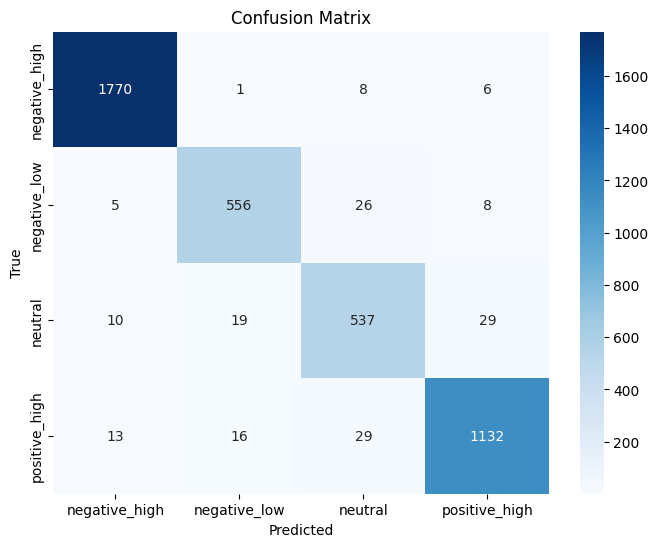

In [1]:
# Imports
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import timm

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()


# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

# Dataset paths
base_dir = '/kaggle/working/rafdb-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model (ConvNeXt or EfficientNet with CBAM trained on 4 classes)
teacher_model = EfficientNetCBAM(num_classes=4).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/rafdb_effnet_cbam_valence_arousal.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            loss = distillation_loss(student_logits, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/rafdb_mbnetv3_student_eff_valence_arousal.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/rafdb_mbnetv3_student_eff_valence_arousal.pth"))
test_and_report(student_model, test_loader)

## Quantization -> RAF-DB Valence Arousal

Device: cuda


Testing Quantized: 100%|██████████| 131/131 [00:23<00:00,  5.49it/s]



Quantized Model Report:
              precision    recall  f1-score   support

           0     0.9840    0.9961    0.9900      1785
           1     0.9540    0.9412    0.9475       595
           2     0.9150    0.9042    0.9096       595
           3     0.9637    0.9580    0.9608      1190

    accuracy                         0.9642      4165
   macro avg     0.9541    0.9499    0.9520      4165
weighted avg     0.9640    0.9642    0.9641      4165



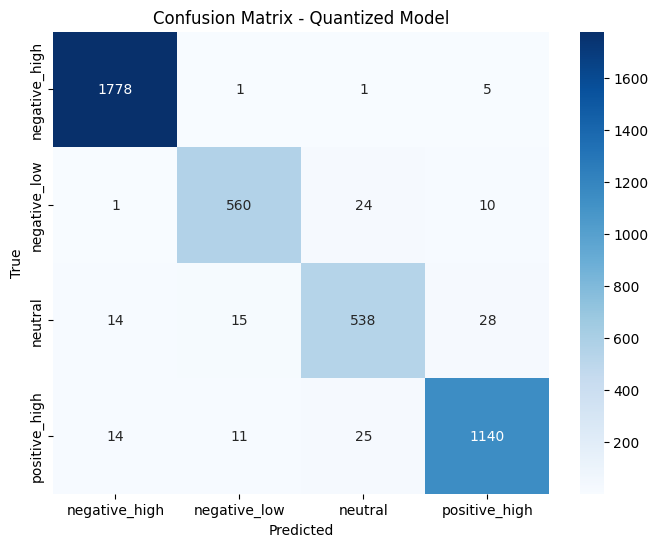

In [2]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/rafdb-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load trained MobileNetV3 Small student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.load_state_dict(torch.load("/kaggle/working/rafdb_mbnetv3_student_eff_valence_arousal.pth"))
student_model.eval()
student_model.to('cpu')  # Quantization must run on CPU

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Evaluation function
def test_quantized(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Quantized"):
            outputs = model(images.to('cpu'))
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).numpy())
            all_labels.extend(labels.numpy())

    print("\nQuantized Model Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Quantized Model')
    plt.show()

# Run evaluation
test_quantized(quantized_model, test_loader)
torch.save(quantized_model.state_dict(), "/kaggle/working/rafdb_mbnetv3_quantized_student_eff_valence_arousal.pth")

# RAF-DB Alert Emotions

## Dataset Filtering for angry, fear, sad, and surprise

In [3]:
import os
from shutil import copy2

# Selected emotions for alert system
selected_emotions = ['angry', 'fear', 'sad', 'surprise']

# Paths
source_base = '/kaggle/input/balanced-raf-db-dataset-7575-grayscale'
target_base = '/kaggle/working/rafdb-alert-emotions'
splits = ['train', 'val', 'test']

# Create new folder structure
for split in splits:
    for emotion in selected_emotions:
        os.makedirs(os.path.join(target_base, split, emotion), exist_ok=True)

# Copy only selected emotion files
for split in splits:
    split_path = os.path.join(source_base, split)
    for emotion in os.listdir(split_path):
        if emotion.lower() in selected_emotions:
            src_folder = os.path.join(split_path, emotion)
            dst_folder = os.path.join(target_base, split, emotion.lower())
            for file in os.listdir(src_folder):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    copy2(os.path.join(src_folder, file), os.path.join(dst_folder, file))

print("Filtered dataset created at:", target_base)

Filtered dataset created at: /kaggle/working/rafdb-alert-emotions


## EfficientNetB3 + CBAM -> RAF-DB Alert Emotions

Device: cuda


/tmp/ipykernel_36/431544944.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/537 [00:00<?, ?it/s]/tmp/ipykernel_36/431544944.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 134/134 [00:13<00:00,  9.78it/s]


Epoch 1/20 | Train Loss: 0.4159, Acc: 70.65% | Val Loss: 0.1038, Acc: 92.16%
Model saved.


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.24it/s]


Epoch 2/20 | Train Loss: 0.0735, Acc: 94.16% | Val Loss: 0.0292, Acc: 97.43%
Model saved.


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.15it/s]


Epoch 3/20 | Train Loss: 0.0290, Acc: 97.67% | Val Loss: 0.0234, Acc: 98.06%
Model saved.


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.21it/s]


Epoch 4/20 | Train Loss: 0.0153, Acc: 98.57% | Val Loss: 0.0180, Acc: 98.95%
Model saved.


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.15it/s]


Epoch 5/20 | Train Loss: 0.0130, Acc: 98.99% | Val Loss: 0.0098, Acc: 99.07%
Model saved.


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.14it/s]


Epoch 6/20 | Train Loss: 0.0110, Acc: 98.99% | Val Loss: 0.0171, Acc: 98.86%


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.19it/s]


Epoch 7/20 | Train Loss: 0.0085, Acc: 99.25% | Val Loss: 0.0094, Acc: 99.32%
Model saved.


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.14it/s]


Epoch 8/20 | Train Loss: 0.0071, Acc: 99.38% | Val Loss: 0.0075, Acc: 99.30%
Model saved.


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.20it/s]


Epoch 9/20 | Train Loss: 0.0057, Acc: 99.57% | Val Loss: 0.0121, Acc: 99.18%


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.14it/s]


Epoch 10/20 | Train Loss: 0.0049, Acc: 99.56% | Val Loss: 0.0081, Acc: 99.42%


Validation: 100%|██████████| 134/134 [00:13<00:00, 10.20it/s]


Epoch 11/20 | Train Loss: 0.0053, Acc: 99.53% | Val Loss: 0.0111, Acc: 99.11%
Early stopping triggered.


Testing: 100%|██████████| 75/75 [00:07<00:00, 10.11it/s]



Classification Report:
              precision    recall  f1-score   support

       angry     0.9950    0.9983    0.9966       595
        fear     0.9983    0.9966    0.9975       595
         sad     0.9899    0.9916    0.9908       595
    surprise     0.9899    0.9866    0.9882       595

    accuracy                         0.9933      2380
   macro avg     0.9933    0.9933    0.9933      2380
weighted avg     0.9933    0.9933    0.9933      2380



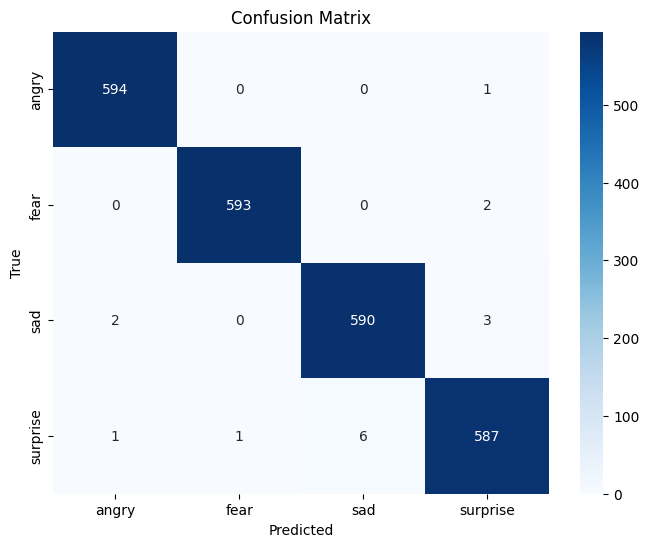

In [4]:
# Reproducibility
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/working/rafdb-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetCBAM(num_classes=4).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 1.5, 1.2, 1.0]).to(device)  # Adjust based on class distribution
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/rafdb_effnet_cbam_alert_emotions.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/rafdb_effnet_cbam_alert_emotions.pth"))
test_and_report(model, test_loader)

## MobileNetV3 Student (Knowledge Distillation) -> Alert Emotions RAF-DB

Device: cuda


/tmp/ipykernel_36/4004071204.py:154: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/537 [00:00<?, ?it/s]/tmp/ipykernel_36/4004071204.py:169: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 134/134 [00:06<00:00, 21.50it/s]


[Student] Epoch 1/30 | Train Loss: 3.8983, Acc: 65.94% | Val Loss: 0.6315, Acc: 76.19%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.47it/s]


[Student] Epoch 2/30 | Train Loss: 1.9399, Acc: 84.53% | Val Loss: 0.3001, Acc: 89.60%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.57it/s]


[Student] Epoch 3/30 | Train Loss: 1.3153, Acc: 90.50% | Val Loss: 0.1821, Acc: 93.61%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.44it/s]


[Student] Epoch 4/30 | Train Loss: 0.9903, Acc: 93.58% | Val Loss: 0.1431, Acc: 94.96%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.67it/s]


[Student] Epoch 5/30 | Train Loss: 0.8140, Acc: 95.26% | Val Loss: 0.1083, Acc: 96.29%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.22it/s]


[Student] Epoch 6/30 | Train Loss: 0.7115, Acc: 96.65% | Val Loss: 0.0787, Acc: 97.18%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.55it/s]


[Student] Epoch 7/30 | Train Loss: 0.6129, Acc: 97.38% | Val Loss: 0.0643, Acc: 97.88%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.23it/s]


[Student] Epoch 8/30 | Train Loss: 0.5630, Acc: 97.79% | Val Loss: 0.0512, Acc: 98.44%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.63it/s]


[Student] Epoch 9/30 | Train Loss: 0.5119, Acc: 98.22% | Val Loss: 0.0440, Acc: 98.62%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.19it/s]


[Student] Epoch 10/30 | Train Loss: 0.4821, Acc: 98.36% | Val Loss: 0.0442, Acc: 98.51%


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.02it/s]


[Student] Epoch 11/30 | Train Loss: 0.4569, Acc: 98.62% | Val Loss: 0.0381, Acc: 98.95%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.40it/s]


[Student] Epoch 12/30 | Train Loss: 0.4236, Acc: 98.86% | Val Loss: 0.0362, Acc: 98.76%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 19.39it/s]


[Student] Epoch 13/30 | Train Loss: 0.3963, Acc: 98.99% | Val Loss: 0.0323, Acc: 99.09%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.04it/s]


[Student] Epoch 14/30 | Train Loss: 0.3900, Acc: 99.01% | Val Loss: 0.0301, Acc: 99.25%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 19.70it/s]


[Student] Epoch 15/30 | Train Loss: 0.3645, Acc: 99.18% | Val Loss: 0.0319, Acc: 98.97%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.35it/s]


[Student] Epoch 16/30 | Train Loss: 0.3606, Acc: 99.19% | Val Loss: 0.0241, Acc: 99.37%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.43it/s]


[Student] Epoch 17/30 | Train Loss: 0.3425, Acc: 99.34% | Val Loss: 0.0244, Acc: 99.37%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.62it/s]


[Student] Epoch 18/30 | Train Loss: 0.3278, Acc: 99.49% | Val Loss: 0.0271, Acc: 99.32%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.45it/s]


[Student] Epoch 19/30 | Train Loss: 0.3203, Acc: 99.46% | Val Loss: 0.0271, Acc: 99.35%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.15it/s]


[Student] Epoch 20/30 | Train Loss: 0.3151, Acc: 99.45% | Val Loss: 0.0245, Acc: 99.37%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.28it/s]


[Student] Epoch 21/30 | Train Loss: 0.3054, Acc: 99.54% | Val Loss: 0.0221, Acc: 99.51%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.08it/s]


[Student] Epoch 22/30 | Train Loss: 0.2995, Acc: 99.45% | Val Loss: 0.0269, Acc: 99.25%


Validation: 100%|██████████| 134/134 [00:06<00:00, 20.84it/s]


[Student] Epoch 23/30 | Train Loss: 0.2949, Acc: 99.55% | Val Loss: 0.0209, Acc: 99.53%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.33it/s]


[Student] Epoch 24/30 | Train Loss: 0.2949, Acc: 99.62% | Val Loss: 0.0225, Acc: 99.44%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.36it/s]


[Student] Epoch 25/30 | Train Loss: 0.2888, Acc: 99.59% | Val Loss: 0.0239, Acc: 99.39%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.92it/s]


[Student] Epoch 26/30 | Train Loss: 0.2866, Acc: 99.60% | Val Loss: 0.0214, Acc: 99.35%


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.77it/s]


[Student] Epoch 27/30 | Train Loss: 0.2819, Acc: 99.60% | Val Loss: 0.0208, Acc: 99.44%
Student model saved.


Validation: 100%|██████████| 134/134 [00:06<00:00, 21.81it/s]


[Student] Epoch 28/30 | Train Loss: 0.2881, Acc: 99.57% | Val Loss: 0.0231, Acc: 99.56%


Validation: 100%|██████████| 134/134 [00:05<00:00, 22.37it/s]


[Student] Epoch 29/30 | Train Loss: 0.2821, Acc: 99.60% | Val Loss: 0.0211, Acc: 99.53%


Validation: 100%|██████████| 134/134 [00:06<00:00, 22.30it/s]


[Student] Epoch 30/30 | Train Loss: 0.2789, Acc: 99.67% | Val Loss: 0.0225, Acc: 99.49%


Testing: 100%|██████████| 75/75 [00:03<00:00, 21.78it/s]



Classification Report:
              precision    recall  f1-score   support

       angry     0.9933    1.0000    0.9966       595
        fear     0.9966    0.9983    0.9975       595
         sad     0.9932    0.9815    0.9873       595
    surprise     0.9883    0.9916    0.9899       595

    accuracy                         0.9929      2380
   macro avg     0.9929    0.9929    0.9928      2380
weighted avg     0.9929    0.9929    0.9928      2380



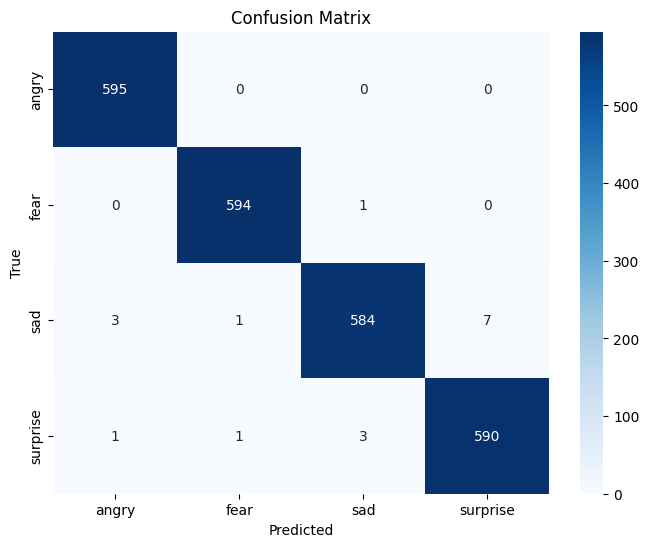

In [5]:
# Imports
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import timm

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()


# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

# Dataset paths
base_dir = '/kaggle/working/rafdb-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model (ConvNeXt or EfficientNet with CBAM trained on 4 classes)
teacher_model = EfficientNetCBAM(num_classes=4).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/rafdb_effnet_cbam_alert_emotions.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            loss = distillation_loss(student_logits, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/rafdb_mbnetv3_student_eff_alert_emotions.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/rafdb_mbnetv3_student_eff_alert_emotions.pth"))
test_and_report(student_model, test_loader)

## Quantization -> RAF-DB Alert Emotions

Device: cuda


Testing Quantized: 100%|██████████| 75/75 [00:11<00:00,  6.64it/s]



Quantized Model Report:
              precision    recall  f1-score   support

           0     0.9966    1.0000    0.9983       595
           1     0.9966    1.0000    0.9983       595
           2     0.9983    0.9832    0.9907       595
           3     0.9883    0.9966    0.9925       595

    accuracy                         0.9950      2380
   macro avg     0.9950    0.9950    0.9949      2380
weighted avg     0.9950    0.9950    0.9949      2380



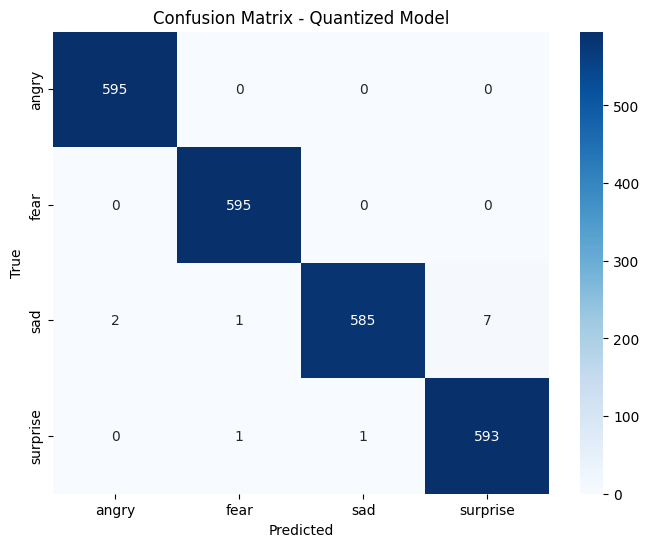

In [6]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/rafdb-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load trained MobileNetV3 Small student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.load_state_dict(torch.load("/kaggle/working/rafdb_mbnetv3_student_eff_alert_emotions.pth"))
student_model.eval()
student_model.to('cpu')  # Quantization must run on CPU

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Evaluation function
def test_quantized(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Quantized"):
            outputs = model(images.to('cpu'))
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).numpy())
            all_labels.extend(labels.numpy())

    print("\nQuantized Model Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Quantized Model')
    plt.show()

# Run evaluation
test_quantized(quantized_model, test_loader)
torch.save(quantized_model.state_dict(), "/kaggle/working/rafdb_mbnetv3_quantized_student_eff_alert_emotions.pth")

# KDEF Dataset

## Subject-Disjoint Dataset Creation

In [1]:
import re
from pathlib import Path
import pandas as pd
import random
import shutil
import sys

ROOT = Path("/kaggle/input/kdef-dataset/KDEF") # source dataset root on Kaggle input
OUT_ROOT = Path("/kaggle/working/kdef-dataset") # desired output root
RANDOM_SEED = 42
TEST_SUBJECTS = 14
VAL_SUBJECTS = 8
# --------------------

EXPR_MAP = {
    "AF": "fear",
    "AN": "angry",
    "DI": "disgust",
    "HA": "happy",
    "NE": "neutral",
    "SA": "sad",
    "SU": "surprise"
}

# Pattern to match filenames like AF01ANFL.JPG
PAT = re.compile(r"^([AB])([FM])(\d{2})(AF|AN|DI|HA|NE|SA|SU)(FL|HL|S|HR|FR)\.(jpe?g|JPE?G)$")

# collect image rows
rows = []
if not ROOT.exists():
    print("ERROR: ROOT path does not exist:", ROOT)
    sys.exit(1)

for folder in ROOT.iterdir():
    if not folder.is_dir():
        continue
    for img in folder.iterdir():
        if not img.is_file():
            continue
        m = PAT.match(img.name)
        if not m:
            # skip unexpected names
            continue
        session, gender, pid, expr_code, angle_code, _ = m.groups()
        subject = f"{gender}{pid}"            # e.g., F01 or M12
        label = EXPR_MAP[expr_code]
        rows.append({
            "src_path": str(img.resolve()),
            "filename": img.name,
            "session": session,
            "gender": gender,
            "subject": subject,
            "identity": int(pid),
            "expression": label,
            "expression_code": expr_code,
            "angle": angle_code
        })

df = pd.DataFrame(rows)
if df.empty:
    print("ERROR: no images parsed. Check ROOT path and filename patterns.")
    sys.exit(1)

# create deterministic subject split
subjects = sorted(df["subject"].unique())
random.seed(RANDOM_SEED)
shuffled = subjects.copy()
random.shuffle(shuffled)

test_n = TEST_SUBJECTS
val_n = VAL_SUBJECTS
train_n = len(shuffled) - test_n - val_n

if train_n <= 0:
    print("ERROR: computed non-positive train count. Check TEST_SUBJECTS/VAL_SUBJECTS.")
    sys.exit(1)

train_subjects = set(shuffled[:train_n])
val_subjects = set(shuffled[train_n:train_n+val_n])
test_subjects = set(shuffled[train_n+val_n:train_n+val_n+test_n])

def assign_split(subject):
    if subject in train_subjects:
        return "train"
    if subject in val_subjects:
        return "val"
    if subject in test_subjects:
        return "test"
    return "unused"

df["split"] = df["subject"].apply(assign_split)

# create output folders
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
for split in ["train", "val", "test"]:
    for lab in labels:
        (OUT_ROOT / split / lab).mkdir(parents=True, exist_ok=True)

# copy files into target layout
copied = 0
for _, row in df.iterrows():
    split = row["split"]
    if split not in {"train","val","test"}:
        continue
    src = Path(row["src_path"])
    dst = OUT_ROOT / split / row["expression"] / row["filename"]
    # avoid overwriting identical existing files
    if not dst.exists():
        try:
            shutil.copy2(src, dst)
            copied += 1
        except Exception as e:
            print("Failed copying", src, "->", dst, ":", e)

# save manifest
OUT_MANIFEST = OUT_ROOT / "kdef_manifest_splits.csv"
df.to_csv(OUT_MANIFEST, index=False)

# summary prints
print(f"Output root: {OUT_ROOT}")
print(f"Parsed images: {len(df)}")
print(f"Copied files: {copied}")
print("Subjects total:", len(subjects))
print("Train/Val/Test subjects:", len(train_subjects), len(val_subjects), len(test_subjects))
print("Image counts per split:")
print(df["split"].value_counts())
print("Image counts per split x label:")
print(df.groupby(["split","expression"]).size().unstack(fill_value=0))
print("Manifest saved to:", OUT_MANIFEST)

Output root: /kaggle/working/kdef-dataset
Parsed images: 4898
Copied files: 4898
Subjects total: 70
Train/Val/Test subjects: 48 8 14
Image counts per split:
split
train    3358
test      980
val       560
Name: count, dtype: int64
Image counts per split x label:
expression  angry  disgust  fear  happy  neutral  sad  surprise
split                                                          
test          140      140   140    140      140  140       140
train         480      480   480    480      480  479       479
val            80       80    80     80       80   80        80
Manifest saved to: /kaggle/working/kdef-dataset/kdef_manifest_splits.csv


In [3]:
# inspect_kdef_folders.py
from pathlib import Path
import pandas as pd

ROOT = Path("/kaggle/working/kdef-dataset")   # change if needed
MANIFEST = ROOT / "kdef_manifest_splits.csv"  # optional

labels = ["angry","disgust","fear","happy","neutral","sad","surprise"]
splits = ["train","val","test"]

def sample_files(folder, n=5):
    files = sorted(folder.glob("*.*"))
    return [f.name for f in files[:n]]

# summary counts
summary = []
total_files = 0
for split in splits:
    for label in labels:
        folder = ROOT / split / label
        if not folder.exists():
            count = 0
            sample = []
        else:
            files = list(folder.glob("*.[jJ][pP][gG]")) + list(folder.glob("*.[jJ][pP][eE][gG]")) + list(folder.glob("*.[pP][nN][gG]"))
            count = len(files)
            sample = [f.name for f in sorted(files)[:5]]
        summary.append({"split": split, "label": label, "count": count, "samples": sample})
        total_files += count

# print table-like summary
print("Summary (split, label, count):")
for row in summary:
    print(f"{row['split']:5} | {row['label']:8} | {row['count']:4} | samples: {row['samples']}")

print("\nTotal images found in folder layout:", total_files)

# compare with manifest if available
if MANIFEST.exists():
    df = pd.read_csv(MANIFEST)
    print("Images recorded in manifest:", len(df))
    # optional per-split counts from manifest
    print("\nManifest counts per split x label:")
    print(df.groupby(["split","expression"]).size().unstack(fill_value=0))
else:
    print("Manifest not found at", MANIFEST)

Summary (split, label, count):
train | angry    |  480 | samples: ['AF01ANFL.JPG', 'AF01ANFR.JPG', 'AF01ANHL.JPG', 'AF01ANHR.JPG', 'AF01ANS.JPG']
train | disgust  |  480 | samples: ['AF01DIFL.JPG', 'AF01DIFR.JPG', 'AF01DIHL.JPG', 'AF01DIHR.JPG', 'AF01DIS.JPG']
train | fear     |  480 | samples: ['AF01AFFL.JPG', 'AF01AFFR.JPG', 'AF01AFHL.JPG', 'AF01AFHR.JPG', 'AF01AFS.JPG']
train | happy    |  480 | samples: ['AF01HAFL.JPG', 'AF01HAFR.JPG', 'AF01HAHL.JPG', 'AF01HAHR.JPG', 'AF01HAS.JPG']
train | neutral  |  480 | samples: ['AF01NEFL.JPG', 'AF01NEFR.JPG', 'AF01NEHL.JPG', 'AF01NEHR.JPG', 'AF01NES.JPG']
train | sad      |  479 | samples: ['AF01SAFL.JPG', 'AF01SAFR.JPG', 'AF01SAHL.JPG', 'AF01SAHR.JPG', 'AF01SAS.JPG']
train | surprise |  479 | samples: ['AF01SUFL.JPG', 'AF01SUFR.JPG', 'AF01SUHL.JPG', 'AF01SUHR.JPG', 'AF01SUS.JPG']
val   | angry    |   80 | samples: ['AF02ANFL.JPG', 'AF02ANFR.JPG', 'AF02ANHL.JPG', 'AF02ANHR.JPG', 'AF02ANS.JPG']
val   | disgust  |   80 | samples: ['AF02DIFL.JPG

In [1]:
import os
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## EfficientNetB3

Device: cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/tmp/ipykernel_36/3302076199.py:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/3302076199.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]


Epoch 1/20 | Train Loss: 2.7180, Acc: 28.74% | Val Loss: 1.9875, Acc: 43.39%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


Epoch 2/20 | Train Loss: 0.9600, Acc: 61.08% | Val Loss: 0.8974, Acc: 62.50%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.44it/s]


Epoch 3/20 | Train Loss: 0.4437, Acc: 79.78% | Val Loss: 1.5207, Acc: 64.46%


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.38it/s]


Epoch 4/20 | Train Loss: 0.2780, Acc: 85.91% | Val Loss: 3.3234, Acc: 76.43%


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.43it/s]


Epoch 5/20 | Train Loss: 0.1885, Acc: 89.64% | Val Loss: 0.4372, Acc: 82.14%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.22it/s]


Epoch 6/20 | Train Loss: 0.1410, Acc: 92.05% | Val Loss: 3.2463, Acc: 81.25%


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


Epoch 7/20 | Train Loss: 0.1188, Acc: 93.92% | Val Loss: 0.4813, Acc: 80.54%


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.41it/s]


Epoch 8/20 | Train Loss: 0.0835, Acc: 95.38% | Val Loss: 0.5674, Acc: 79.82%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:11<00:00,  2.76it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.7982    0.6214    0.6988       140
           1     0.6982    0.8429    0.7638       140
           2     0.6377    0.6286    0.6331       140
           3     0.9020    0.9857    0.9420       140
           4     0.8029    0.7857    0.7942       140
           5     0.6643    0.6786    0.6714       140
           6     0.7939    0.7429    0.7675       140

    accuracy                         0.7551       980
   macro avg     0.7567    0.7551    0.7530       980
weighted avg     0.7567    0.7551    0.7530       980



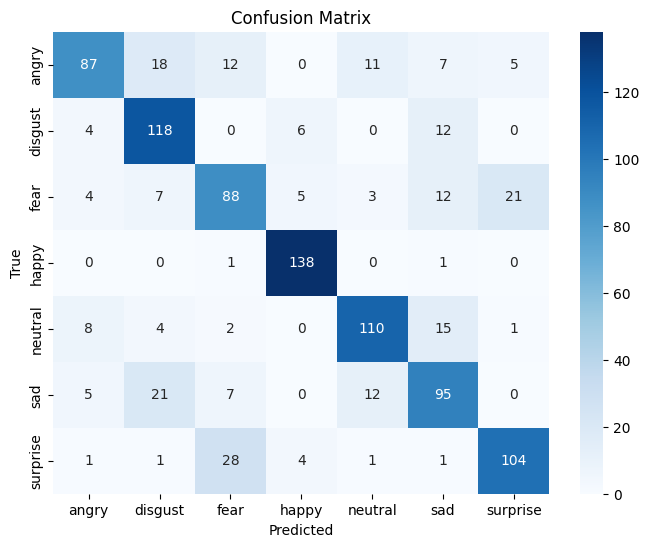

In [2]:
# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# EfficientNetB3 model
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=7).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 2.0, 2.5, 1.0, 1.2, 1.5, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_b3_kdef.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/efficientnet_b3_kdef.pth"))
test_and_report(model, test_loader)

## EfficientNetB3 + Channel Attention

Device: cuda


/tmp/ipykernel_36/2392511726.py:104: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/2392511726.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


Epoch 1/20 | Train Loss: 2.0066, Acc: 27.93% | Val Loss: 2.1981, Acc: 48.39%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


Epoch 2/20 | Train Loss: 0.7331, Acc: 65.69% | Val Loss: 0.7321, Acc: 68.21%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


Epoch 3/20 | Train Loss: 0.3568, Acc: 82.58% | Val Loss: 0.5475, Acc: 74.29%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


Epoch 4/20 | Train Loss: 0.2047, Acc: 88.62% | Val Loss: 0.4607, Acc: 77.86%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.42it/s]


Epoch 5/20 | Train Loss: 0.1529, Acc: 91.33% | Val Loss: 0.3838, Acc: 81.25%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.60it/s]


Epoch 6/20 | Train Loss: 0.1102, Acc: 94.04% | Val Loss: 0.3777, Acc: 81.07%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.34it/s]


Epoch 7/20 | Train Loss: 0.0819, Acc: 94.88% | Val Loss: 0.4779, Acc: 81.79%


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


Epoch 8/20 | Train Loss: 0.0716, Acc: 95.89% | Val Loss: 0.3959, Acc: 83.93%


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.60it/s]


Epoch 9/20 | Train Loss: 0.0614, Acc: 96.69% | Val Loss: 0.4478, Acc: 82.32%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:06<00:00,  4.49it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.7398    0.6500    0.6920       140
           1     0.8125    0.8357    0.8239       140
           2     0.6923    0.7071    0.6996       140
           3     0.9846    0.9143    0.9481       140
           4     0.9074    0.7000    0.7903       140
           5     0.6522    0.8571    0.7407       140
           6     0.8243    0.8714    0.8472       140

    accuracy                         0.7908       980
   macro avg     0.8019    0.7908    0.7917       980
weighted avg     0.8019    0.7908    0.7917       980



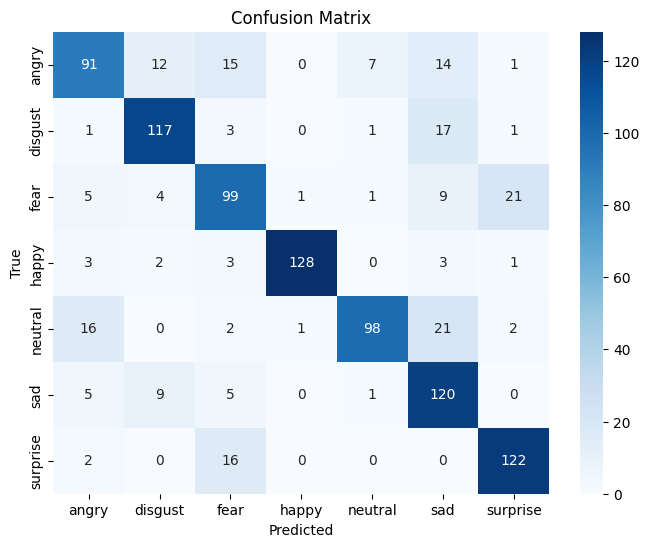

In [3]:
# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Channel Attention only
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# EfficientNetB3 + Channel Attention
class EfficientNetChannelAttention(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.channel_attention = ChannelAttention(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = x * self.channel_attention(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetChannelAttention(num_classes=7).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 2.0, 2.5, 1.0, 1.2, 1.5, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_ca_kdef.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/efficientnet_ca_kdef.pth"))
test_and_report(model, test_loader)

## EfficientNetB3 + Spatial Attention

Device: cuda


/tmp/ipykernel_36/181819353.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/181819353.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:03<00:00,  4.61it/s]


Epoch 1/20 | Train Loss: 1.9964, Acc: 27.49% | Val Loss: 1.1922, Acc: 48.39%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]


Epoch 2/20 | Train Loss: 0.7403, Acc: 65.93% | Val Loss: 0.6682, Acc: 67.86%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]


Epoch 3/20 | Train Loss: 0.3660, Acc: 81.03% | Val Loss: 0.5831, Acc: 71.79%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.50it/s]


Epoch 4/20 | Train Loss: 0.2227, Acc: 88.30% | Val Loss: 0.4707, Acc: 77.86%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


Epoch 5/20 | Train Loss: 0.1575, Acc: 91.16% | Val Loss: 0.5205, Acc: 76.61%


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.58it/s]


Epoch 6/20 | Train Loss: 0.1133, Acc: 93.27% | Val Loss: 0.4918, Acc: 82.14%


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]


Epoch 7/20 | Train Loss: 0.0962, Acc: 94.76% | Val Loss: 0.6119, Acc: 80.18%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.7642    0.6714    0.7148       140
           1     0.8559    0.7214    0.7829       140
           2     0.5368    0.7286    0.6182       140
           3     0.9270    0.9071    0.9170       140
           4     0.8647    0.8214    0.8425       140
           5     0.6205    0.7357    0.6732       140
           6     0.8496    0.6857    0.7589       140

    accuracy                         0.7531       980
   macro avg     0.7741    0.7531    0.7582       980
weighted avg     0.7741    0.7531    0.7582       980



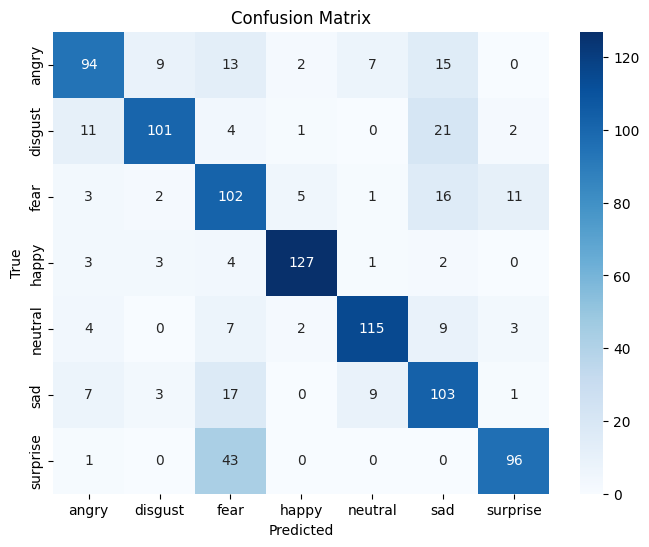

In [4]:
# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Spatial Attention only
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# EfficientNetB3 + Spatial Attention
class EfficientNetSpatialAttention(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.spatial_attention = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = x * self.spatial_attention(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetSpatialAttention(num_classes=7).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 2.0, 2.5, 1.0, 1.2, 1.5, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_sa_kdef.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/efficientnet_sa_kdef.pth"))
test_and_report(model, test_loader)

## EfficientNetB3 + CBAM

Device: cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/tmp/ipykernel_36/2736024526.py:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/2736024526.py:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:04<00:00,  4.29it/s]


Epoch 1/20 | Train Loss: 1.7245, Acc: 30.82% | Val Loss: 1.3931, Acc: 56.96%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.07it/s]


Epoch 2/20 | Train Loss: 0.6800, Acc: 67.93% | Val Loss: 0.7095, Acc: 68.75%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch 3/20 | Train Loss: 0.3401, Acc: 82.67% | Val Loss: 0.5465, Acc: 74.46%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.97it/s]


Epoch 4/20 | Train Loss: 0.2061, Acc: 87.91% | Val Loss: 0.5282, Acc: 78.57%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.02it/s]


Epoch 5/20 | Train Loss: 0.1590, Acc: 91.27% | Val Loss: 0.4010, Acc: 79.29%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]


Epoch 6/20 | Train Loss: 0.1266, Acc: 93.03% | Val Loss: 0.4748, Acc: 82.32%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.01it/s]


Epoch 7/20 | Train Loss: 0.1059, Acc: 94.04% | Val Loss: 0.3907, Acc: 84.11%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]


Epoch 8/20 | Train Loss: 0.0803, Acc: 95.41% | Val Loss: 0.4631, Acc: 84.46%


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.97it/s]


Epoch 9/20 | Train Loss: 0.0618, Acc: 96.40% | Val Loss: 0.3997, Acc: 83.21%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]


Epoch 10/20 | Train Loss: 0.0510, Acc: 96.87% | Val Loss: 0.3524, Acc: 85.18%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.00it/s]


Epoch 11/20 | Train Loss: 0.0569, Acc: 96.63% | Val Loss: 0.3876, Acc: 83.04%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]


Epoch 12/20 | Train Loss: 0.0440, Acc: 97.74% | Val Loss: 3.4389, Acc: 85.71%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch 13/20 | Train Loss: 0.0398, Acc: 97.62% | Val Loss: 0.3162, Acc: 87.50%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.17it/s]


Epoch 14/20 | Train Loss: 0.0367, Acc: 97.41% | Val Loss: 0.3716, Acc: 88.21%


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.89it/s]


Epoch 15/20 | Train Loss: 0.0367, Acc: 97.83% | Val Loss: 8.3495, Acc: 85.89%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.49it/s]


Epoch 16/20 | Train Loss: 0.0338, Acc: 97.89% | Val Loss: 0.4739, Acc: 88.75%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.8092    0.7571    0.7823       140
           1     0.8864    0.8357    0.8603       140
           2     0.7192    0.7500    0.7343       140
           3     0.9855    0.9714    0.9784       140
           4     0.9580    0.8143    0.8803       140
           5     0.6667    0.8429    0.7445       140
           6     0.8978    0.8786    0.8881       140

    accuracy                         0.8357       980
   macro avg     0.8461    0.8357    0.8383       980
weighted avg     0.8461    0.8357    0.8383       980



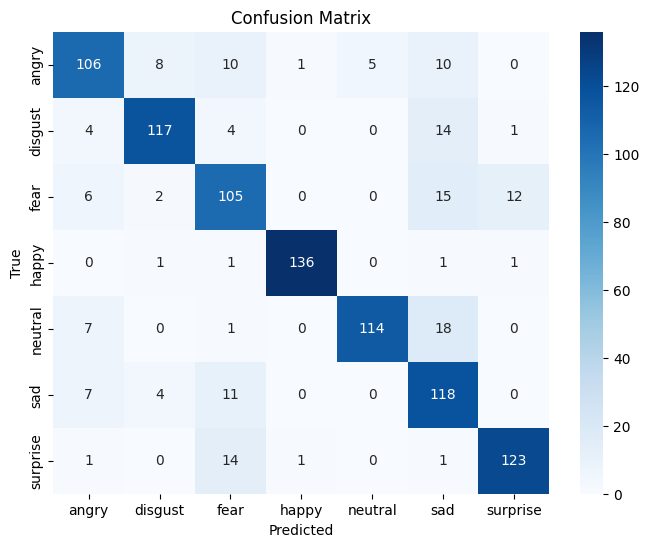

In [1]:
# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetCBAM(num_classes=7).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 2.0, 2.5, 1.0, 1.2, 1.5, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_cbam_kdef.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_kdef.pth"))
test_and_report(model, test_loader)

### Grad-CAM

In [3]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.2 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.

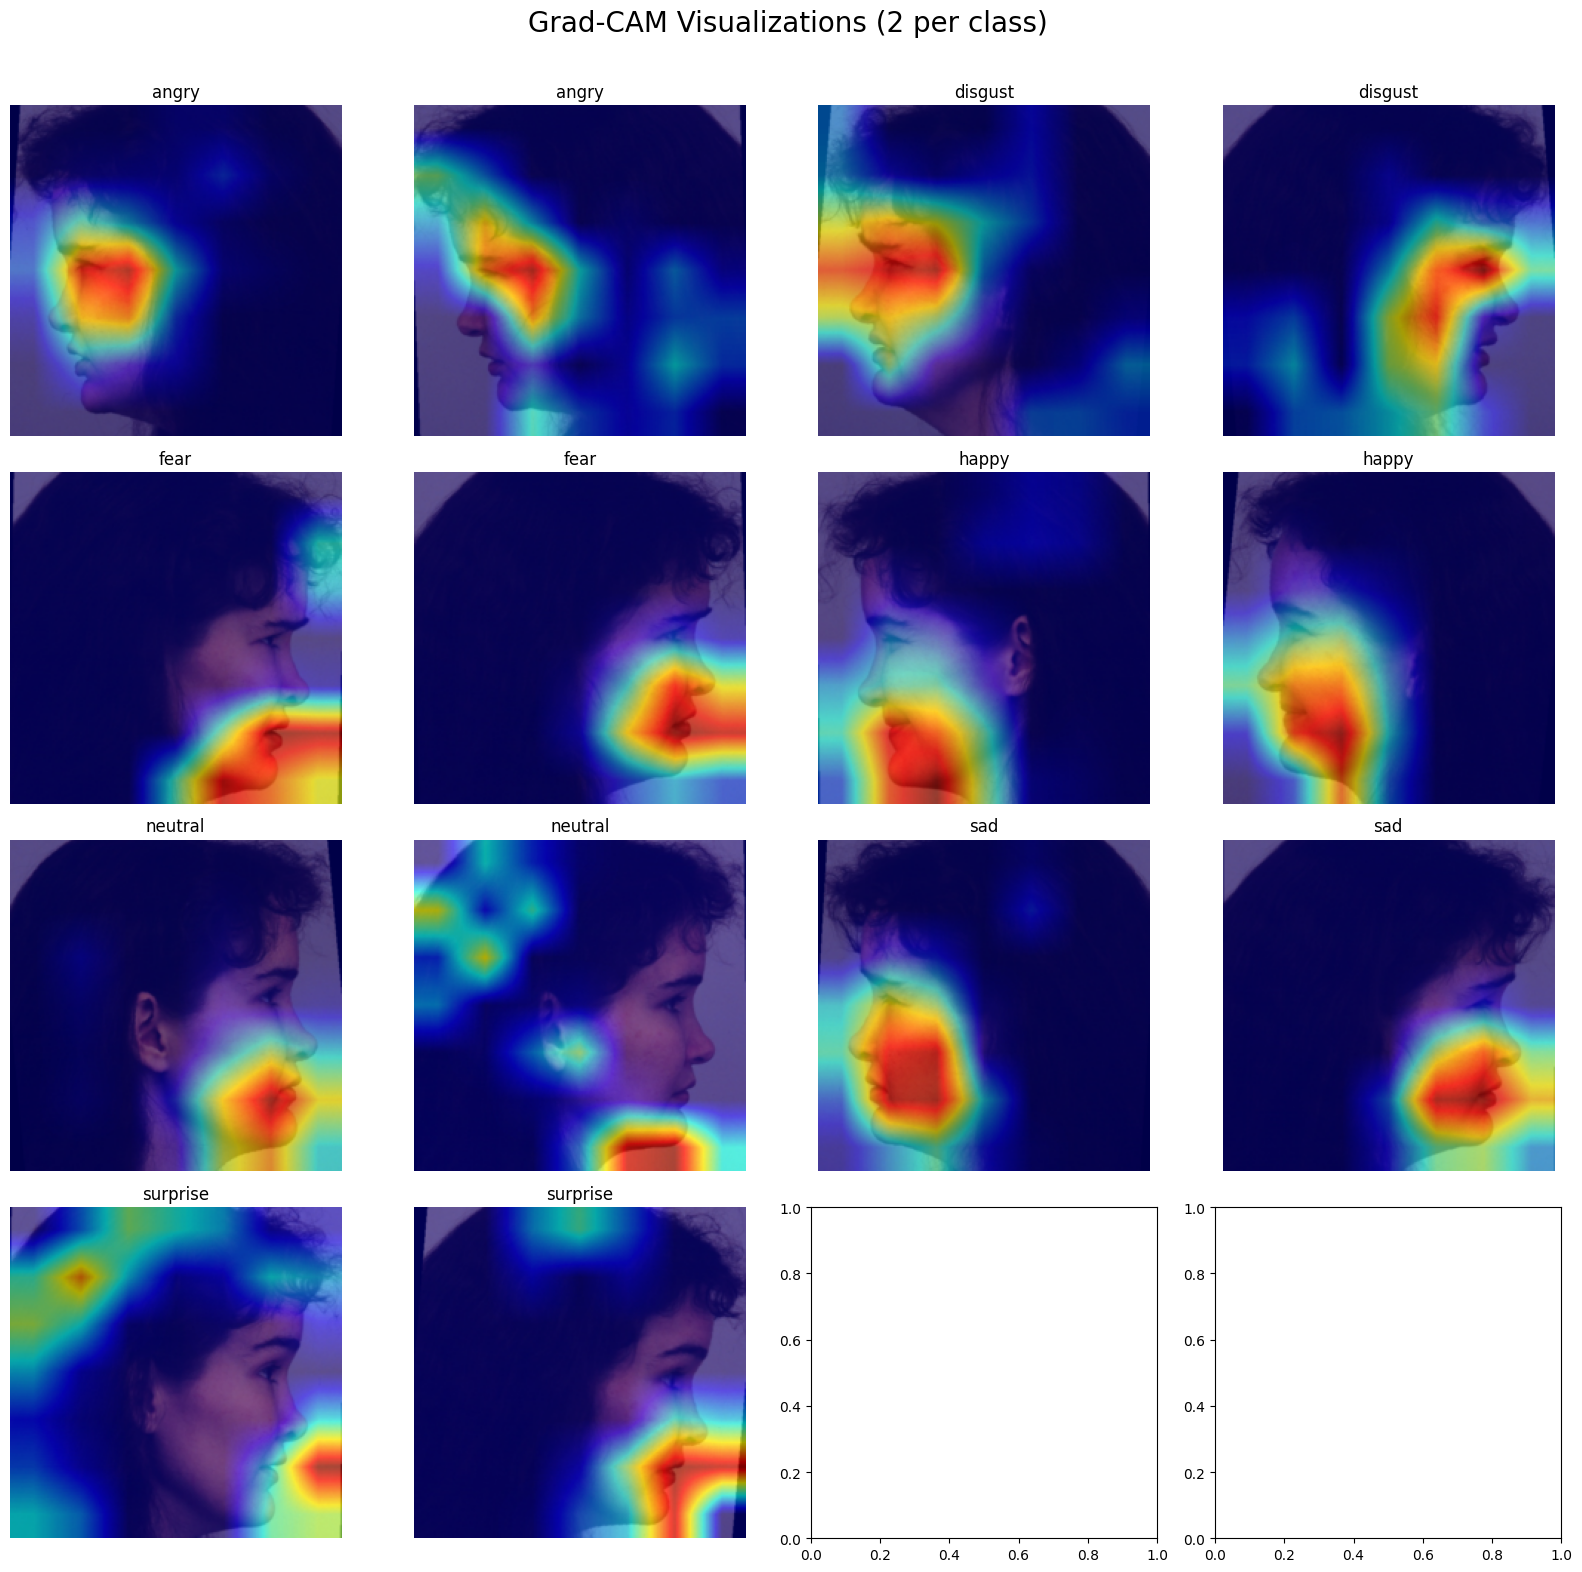

In [7]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def visualize_gradcam_grid(model, dataset, target_layer, num_images_per_class=2):
    cam = GradCAM(model=model, target_layers=[target_layer])
    class_to_images = {i: [] for i in range(len(dataset.classes))}

    # Collect 2 images per class
    for i in range(len(dataset)):
        image_tensor, label = dataset[i]
        if len(class_to_images[label]) < num_images_per_class:
            class_to_images[label].append((image_tensor, label))
        if all(len(imgs) >= num_images_per_class for imgs in class_to_images.values()):
            break

    # Prepare grid
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle("Grad-CAM Visualizations (2 per class)", fontsize=20)

    idx = 0
    for class_id, images in class_to_images.items():
        for image_tensor, label in images:
            input_tensor = image_tensor.unsqueeze(0).to(device)

            rgb_image = image_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_image = (rgb_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
            rgb_image = np.clip(rgb_image, 0, 1)

            targets = [ClassifierOutputTarget(label)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
            visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

            ax = axes[idx // 4, idx % 4]
            ax.imshow(visualization)
            ax.set_title(f"{dataset.classes[label]}", fontsize=12)
            ax.axis('off')
            idx += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Usage
target_layer = model.base.conv_head
visualize_gradcam_grid(model, test_dataset, target_layer, num_images_per_class=2)

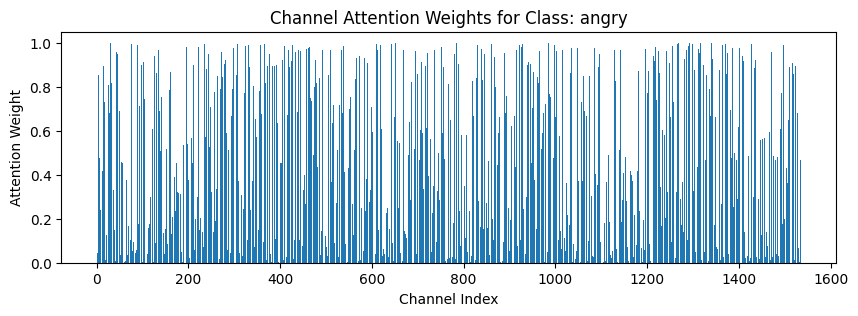

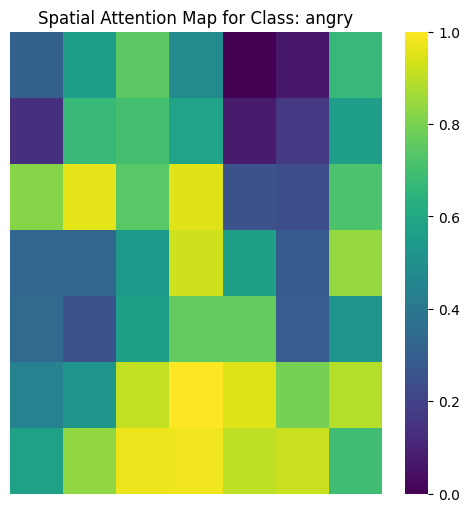

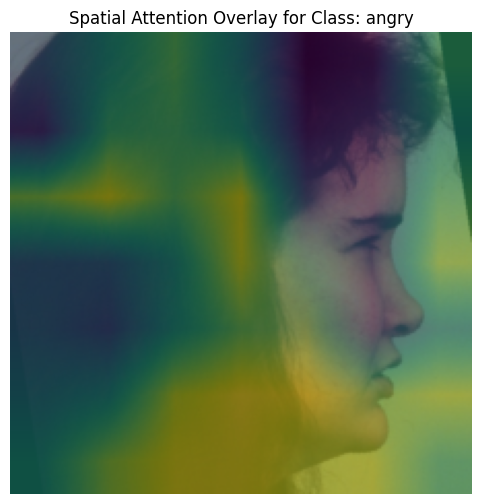

In [9]:
def visualize_cbam_attention(model, image_tensor, label=None, class_names=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.base.forward_features(image_tensor)
        channel_att = model.cbam.channel_attention(features)
        spatial_att = model.cbam.spatial_attention(features)

    # Optional class label
    class_title = f" for Class: {class_names[label]}" if label is not None and class_names else ""

    # Channel Attention: plot as bar chart
    avg_channel_att = channel_att.mean(dim=(2, 3)).squeeze().cpu().numpy()
    avg_channel_att = np.clip(avg_channel_att, 0, 1)
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(avg_channel_att)), avg_channel_att)
    plt.title(f"Channel Attention Weights{class_title}")
    plt.xlabel("Channel Index")
    plt.ylabel("Attention Weight")
    plt.show()

    
    # Spatial Attention
    spatial_map = spatial_att.squeeze().cpu().numpy()
    spatial_map = (spatial_map - spatial_map.min()) / (spatial_map.max() - spatial_map.min() + 1e-8)
    plt.figure(figsize=(6, 6))
    sns.heatmap(spatial_map, cmap='viridis')
    plt.title(f"Spatial Attention Map{class_title}")
    plt.axis('off')
    plt.show()

    # Overlay on image
    rgb_image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb_image = (rgb_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    rgb_image = np.clip(rgb_image, 0, 1)

    spatial_map_resized = np.array(Image.fromarray(spatial_map).resize((224, 224), resample=Image.BILINEAR))
    heatmap = plt.cm.viridis(spatial_map_resized)[..., :3]
    overlay = 0.5 * rgb_image + 0.5 * heatmap

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"Spatial Attention Overlay{class_title}")
    plt.axis('off')
    plt.show()

# Usage
image_tensor, label = test_dataset[0]
visualize_cbam_attention(model, image_tensor, label=label, class_names=test_dataset.classes)

## MobileNetV3 Student (Knowledge Distillation)

Device: cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 44.6MB/s]
/tmp/ipykernel_36/2193020114.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/2193020114.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s]


[Student] Epoch 1/30 | Train Loss: 5.6547, Acc: 25.85% | Val Loss: 1.5571, Acc: 39.29%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.52it/s]


[Student] Epoch 2/30 | Train Loss: 3.5661, Acc: 53.66% | Val Loss: 1.0939, Acc: 55.18%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]


[Student] Epoch 3/30 | Train Loss: 2.1929, Acc: 68.70% | Val Loss: 0.9429, Acc: 64.64%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]


[Student] Epoch 4/30 | Train Loss: 1.6378, Acc: 76.15% | Val Loss: 0.8541, Acc: 69.82%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


[Student] Epoch 5/30 | Train Loss: 1.3845, Acc: 80.55% | Val Loss: 0.7800, Acc: 72.86%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


[Student] Epoch 6/30 | Train Loss: 1.1871, Acc: 83.80% | Val Loss: 0.6673, Acc: 75.18%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.38it/s]


[Student] Epoch 7/30 | Train Loss: 1.1030, Acc: 85.29% | Val Loss: 0.6859, Acc: 73.21%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


[Student] Epoch 8/30 | Train Loss: 0.9730, Acc: 87.52% | Val Loss: 0.6418, Acc: 75.89%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.69it/s]


[Student] Epoch 9/30 | Train Loss: 0.9233, Acc: 88.95% | Val Loss: 0.5931, Acc: 78.93%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]


[Student] Epoch 10/30 | Train Loss: 0.8360, Acc: 89.85% | Val Loss: 0.6093, Acc: 76.79%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.25it/s]


[Student] Epoch 11/30 | Train Loss: 0.8548, Acc: 89.37% | Val Loss: 0.6916, Acc: 76.96%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s]


[Student] Epoch 12/30 | Train Loss: 0.7764, Acc: 91.51% | Val Loss: 0.5728, Acc: 80.36%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.44it/s]


[Student] Epoch 13/30 | Train Loss: 0.7589, Acc: 91.75% | Val Loss: 0.6351, Acc: 77.68%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]


[Student] Epoch 14/30 | Train Loss: 0.7130, Acc: 92.38% | Val Loss: 0.6022, Acc: 79.46%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.43it/s]


[Student] Epoch 15/30 | Train Loss: 0.6936, Acc: 92.29% | Val Loss: 0.5888, Acc: 77.68%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]


[Student] Epoch 16/30 | Train Loss: 0.6491, Acc: 93.30% | Val Loss: 0.5805, Acc: 79.29%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.47it/s]


[Student] Epoch 17/30 | Train Loss: 0.6639, Acc: 93.06% | Val Loss: 0.6192, Acc: 78.39%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:05<00:00,  5.52it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.7083    0.7286    0.7183       140
           1     0.7517    0.7786    0.7649       140
           2     0.6923    0.6429    0.6667       140
           3     0.9392    0.9929    0.9653       140
           4     0.8731    0.8357    0.8540       140
           5     0.6641    0.6214    0.6421       140
           6     0.7905    0.8357    0.8125       140

    accuracy                         0.7765       980
   macro avg     0.7742    0.7765    0.7748       980
weighted avg     0.7742    0.7765    0.7748       980



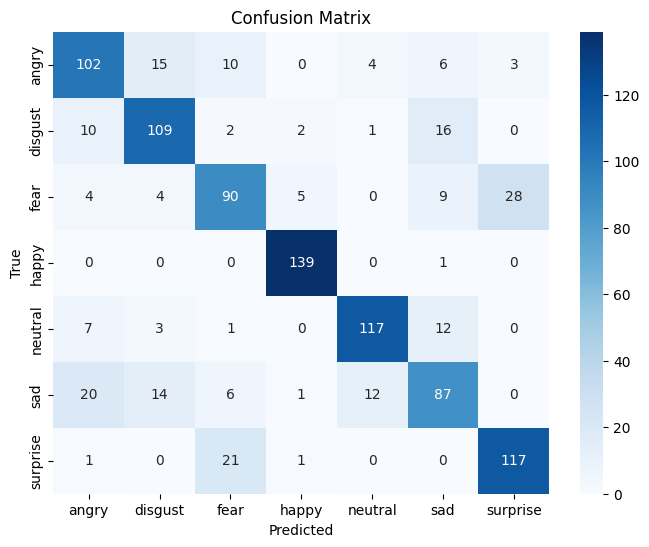

In [3]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model
teacher_model = EfficientNetCBAM(num_classes=7).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_kdef.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 7)
student_model.num_classes = 7
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            student_outputs = student_logits.view(images.size(0), -1)
            loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.view(images.size(0), -1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/mobilenetv3_student_kdef.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/mobilenetv3_student_kdef.pth"))
test_and_report(student_model, test_loader)

## Quantization

Device: cuda


Testing Quantized: 100%|██████████| 31/31 [00:08<00:00,  3.74it/s]



Quantized Model Report:
              precision    recall  f1-score   support

           0     0.7293    0.6929    0.7106       140
           1     0.7586    0.7857    0.7719       140
           2     0.7481    0.7000    0.7232       140
           3     0.9388    0.9857    0.9617       140
           4     0.8444    0.8143    0.8291       140
           5     0.6552    0.6786    0.6667       140
           6     0.8264    0.8500    0.8380       140

    accuracy                         0.7867       980
   macro avg     0.7858    0.7867    0.7859       980
weighted avg     0.7858    0.7867    0.7859       980



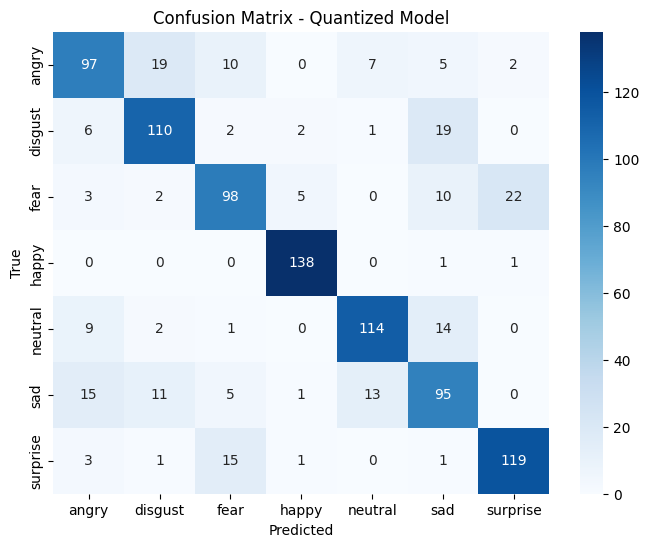

In [4]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load trained MobileNetV3 Small student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 7)
student_model.num_classes = 7
student_model.load_state_dict(torch.load("/kaggle/working/mobilenetv3_student_kdef.pth"))
student_model.eval()
student_model.to('cpu')  # Quantization must run on CPU

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Evaluation function
def test_quantized(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Quantized"):
            outputs = model(images.to('cpu'))
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).numpy())
            all_labels.extend(labels.numpy())

    print("\nQuantized Model Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Quantized Model')
    plt.show()

# Run evaluation
test_quantized(quantized_model, test_loader)
torch.save(quantized_model.state_dict(), "/kaggle/working/mobilenetv3_quantized_kdef.pth")

## Swin Transformer

In [1]:
import os
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: cuda


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

/tmp/ipykernel_36/348829502.py:80: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/348829502.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


Epoch 1/20 | Train Loss: 1.2342, Acc: 46.13% | Val Loss: 0.4782, Acc: 75.36%
Model saved.


Validation: 100%|██████████| 18/18 [00:07<00:00,  2.33it/s]


Epoch 2/20 | Train Loss: 0.4239, Acc: 75.91% | Val Loss: 0.3394, Acc: 81.96%
Model saved.


Validation: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Epoch 3/20 | Train Loss: 0.2864, Acc: 84.46% | Val Loss: 0.2988, Acc: 81.07%
Model saved.


Validation: 100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


Epoch 4/20 | Train Loss: 0.2463, Acc: 85.38% | Val Loss: 0.3109, Acc: 82.32%


Validation: 100%|██████████| 18/18 [00:07<00:00,  2.35it/s]


Epoch 5/20 | Train Loss: 0.1806, Acc: 88.80% | Val Loss: 0.3183, Acc: 84.82%


Validation: 100%|██████████| 18/18 [00:07<00:00,  2.35it/s]


Epoch 6/20 | Train Loss: 0.1571, Acc: 90.50% | Val Loss: 0.3263, Acc: 86.96%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:13<00:00,  2.33it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.8500    0.7286    0.7846       140
           1     0.8919    0.7071    0.7888       140
           2     0.5813    0.8429    0.6880       140
           3     0.9640    0.9571    0.9606       140
           4     0.9833    0.8429    0.9077       140
           5     0.6842    0.9286    0.7879       140
           6     0.9381    0.6500    0.7679       140

    accuracy                         0.8082       980
   macro avg     0.8418    0.8082    0.8122       980
weighted avg     0.8418    0.8082    0.8122       980



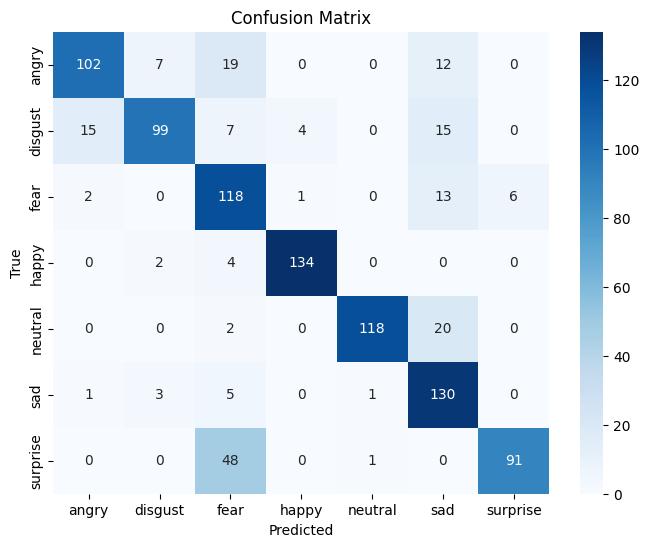

In [2]:
# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms (192x192 for SwinV2)
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(192),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class SwinV2Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.base = timm.create_model('swinv2_base_window12_192.ms_in22k', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.base(x)

model = SwinV2Classifier(num_classes=7).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 2.0, 2.5, 1.0, 1.2, 1.5, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/swin_kdef.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/swin_kdef.pth"))
test_and_report(model, test_loader)

In [8]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [9]:
torch.cuda.empty_cache()

## ConvNext + CBAM

Device: cuda


/tmp/ipykernel_36/3305669365.py:130: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/210 [00:00<?, ?it/s]/tmp/ipykernel_36/3305669365.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 1/20 | Train Loss: 0.7096, Acc: 64.95% | Val Loss: 0.6934, Acc: 69.64%
Model saved.


Validation: 100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch 2/20 | Train Loss: 0.3126, Acc: 82.76% | Val Loss: 0.3534, Acc: 86.07%
Model saved.


Validation: 100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 3/20 | Train Loss: 0.2087, Acc: 88.12% | Val Loss: 0.3920, Acc: 84.29%


Validation: 100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch 4/20 | Train Loss: 0.1751, Acc: 91.57% | Val Loss: 0.4584, Acc: 83.93%


Validation: 100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 5/20 | Train Loss: 0.1340, Acc: 93.03% | Val Loss: 0.2026, Acc: 90.00%
Model saved.


Validation: 100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 6/20 | Train Loss: 0.1167, Acc: 93.63% | Val Loss: 0.3010, Acc: 85.71%


Validation: 100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 7/20 | Train Loss: 0.1119, Acc: 94.58% | Val Loss: 0.4314, Acc: 83.39%


Validation: 100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch 8/20 | Train Loss: 0.0814, Acc: 95.59% | Val Loss: 0.5138, Acc: 81.43%


Validation: 100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 9/20 | Train Loss: 0.0464, Acc: 97.77% | Val Loss: 0.2494, Acc: 89.64%


Validation: 100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 10/20 | Train Loss: 0.0222, Acc: 98.84% | Val Loss: 0.2892, Acc: 89.29%
Early stopping triggered.


Testing: 100%|██████████| 62/62 [00:29<00:00,  2.10it/s]



Classification Report:
              precision    recall  f1-score   support

           0     0.9429    0.7071    0.8082       140
           1     0.8939    0.8429    0.8676       140
           2     0.7941    0.7714    0.7826       140
           3     1.0000    0.9571    0.9781       140
           4     0.7514    0.9714    0.8474       140
           5     0.7451    0.8143    0.7782       140
           6     0.9065    0.9000    0.9032       140

    accuracy                         0.8520       980
   macro avg     0.8620    0.8520    0.8522       980
weighted avg     0.8620    0.8520    0.8522       980



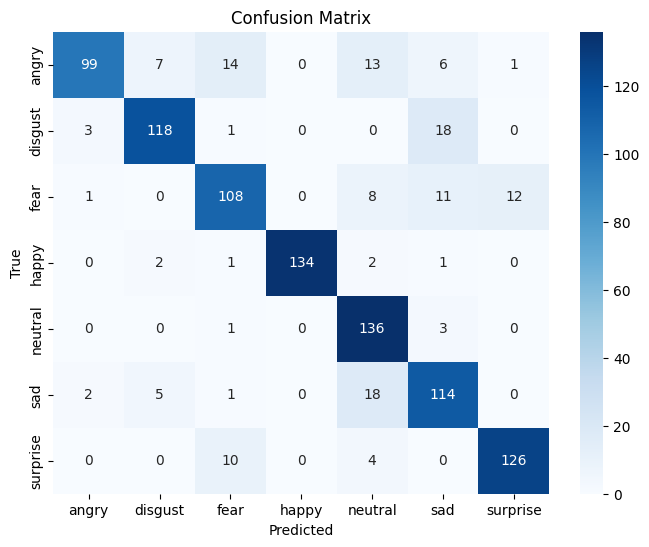

In [4]:
# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# ConvNeXt V2 Large + CBAM model
class ConvNeXtCBAM(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.base = timm.create_model('convnextv2_large', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)
        self.pool = nn.AdaptiveAvgPool2d(1)  # Add pooling layer
        self.classifier = nn.Linear(1536, num_classes)  # Replace base.head.fc

    def forward(self, x):
        x = self.base.forward_features(x)  # [B, 1536, H, W]
        x = self.cbam(x)                   # [B, 1536, H, W]
        x = self.pool(x)                   # [B, 1536, 1, 1]
        x = x.view(x.size(0), -1)          # [B, 1536]
        x = self.classifier(x)             # [B, num_classes]
        return x

model = ConvNeXtCBAM(num_classes=7).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 2.0, 2.5, 1.0, 1.2, 1.5, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
scaler = torch.cuda.amp.GradScaler()

patience_stop = 5

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    torch.cuda.empty_cache()
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/convnext_cbam_kdef.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience_stop:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/convnext_cbam_kdef.pth"))
test_and_report(model, test_loader)

In [5]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

## ConvNextV2 + CBAM (Aggressive Version)

In [ ]:
# =========================================================
# Workflow Overview (Quick Reference)
# =========================================================

# 1. Reproducibility: Set seeds (random, numpy, torch, cuda)
# 2. Device setup: Use GPU if available
# 3. Transforms:
#    - Train: strong augmentations (crop, flip, color, blur, erase)
#    - Eval: clean preprocessing (resize, center crop)
# 4. CBAM Attention:
#    - Channel attention: emphasizes key feature maps
#    - Spatial attention: emphasizes key spatial regions
# 5. Loss:
#    - FocalLoss (focus on hard samples) or LabelSmoothed CE
# 6. Dataset & Sampling:
#    - Load train/val/test from folders
#    - WeightedRandomSampler balances minority classes
# 7. Model:
#    - ConvNeXtV2 Large (pretrained backbone)
#    - Add CBAM, pooling, dropout, linear classifier
# 8. Optimizer & LR Scheduler:
#    - AdamW with discriminative LRs
#    - OneCycleLR for dynamic learning rate schedule
# 9. Training Loop:
#    - Forward + AMP (GradScaler)
#    - Loss backward, gradient clipping, optimizer/scheduler step
#    - Early stopping + checkpoint saving on val improvement
# 10. Testing:
#    - Load best checkpoint
#    - Use TTA (flip averaging)
#    - Generate classification report + confusion matrix

Device: cuda


/tmp/ipykernel_36/2996911467.py:224: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/2996911467.py:257: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/25 | Train 0.8242, 61.73% | Val 0.3627, 80.54%  -> saved


Epoch 2/25 | Train 0.3394, 80.91% | Val 0.3786, 83.21%


Epoch 3/25 | Train 0.2922, 83.98% | Val 0.4874, 80.71%


Epoch 4/25 | Train 0.2497, 86.21% | Val 0.1965, 88.93%  -> saved


Epoch 5/25 | Train 0.2076, 89.31% | Val 0.3237, 86.25%


Epoch 6/25 | Train 0.1826, 90.53% | Val 0.2122, 89.11%


Epoch 7/25 | Train 0.1525, 91.54% | Val 0.2095, 90.71%


Epoch 8/25 | Train 0.1310, 93.30% | Val 0.2174, 90.00%


Epoch 9/25 | Train 0.1119, 93.33% | Val 0.1552, 91.61%  -> saved


Epoch 10/25 | Train 0.0863, 95.15% | Val 0.1398, 92.68%  -> saved


Epoch 11/25 | Train 0.0831, 95.50% | Val 0.3588, 86.43%


Epoch 12/25 | Train 0.0698, 96.10% | Val 0.2717, 88.04%


Epoch 13/25 | Train 0.0549, 96.52% | Val 0.2391, 90.36%


Epoch 14/25 | Train 0.0477, 97.29% | Val 0.2123, 91.25%


Epoch 15/25 | Train 0.0491, 97.65% | Val 0.1926, 90.36%


Epoch 16/25 | Train 0.0334, 97.95% | Val 0.1496, 92.32%


Epoch 17/25 | Train 0.0250, 98.57% | Val 0.2328, 90.18%


Epoch 18/25 | Train 0.0287, 98.51% | Val 0.2180, 91.96%


Epoch 19/25 | Train 0.0259, 98.81% | Val 0.2098, 91.96%


Epoch 20/25 | Train 0.0187, 98.93% | Val 0.1721, 92.14%
Early stopping triggered.



Classification Report (macro focus):
              precision    recall  f1-score   support

       angry     0.9444    0.7286    0.8226       140
     disgust     0.8417    0.8357    0.8387       140
        fear     0.7239    0.8429    0.7789       140
       happy     0.9929    1.0000    0.9964       140
     neutral     0.9437    0.9571    0.9504       140
         sad     0.7610    0.8643    0.8094       140
    surprise     0.9219    0.8429    0.8806       140

    accuracy                         0.8673       980
   macro avg     0.8756    0.8673    0.8681       980
weighted avg     0.8756    0.8673    0.8681       980



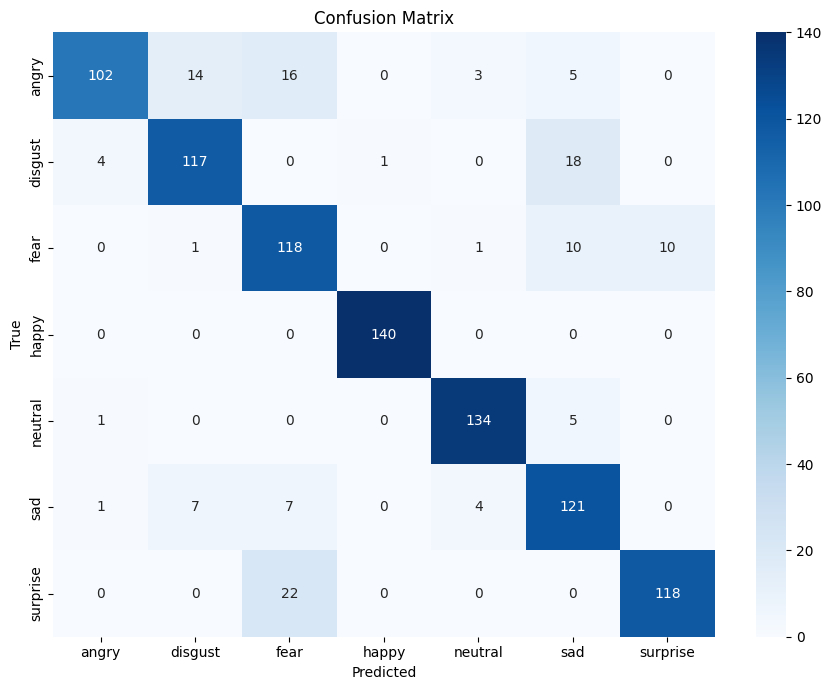

In [6]:
import os
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F

# =========================================================
# Device setup
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.cuda.empty_cache()

# =========================================================
# Transforms (train strong, val/test clean)
# =========================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random')
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =========================================================
# CBAM modules
# =========================================================
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, max(1, in_planes // ratio), 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(max(1, in_planes // ratio), in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# =========================================================
# Focal loss (optional, can toggle to label-smoothed CE)
# =========================================================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term = focal_term * alpha_t
        loss = focal_term * log_probs
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# =========================================================
# Dataset paths
# =========================================================
base_dir = '/kaggle/input/official-kdef-dataset/kdef-dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

# Load datasets with respective transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=eval_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=eval_transform)

# =========================================================
# Weighted sampler to boost minority classes (fear/surprise/disgust)
# =========================================================
# Compute class counts from train dataset
class_indices = [label for _, label in train_dataset.samples]
num_classes = len(train_dataset.classes)
class_counts = np.bincount(class_indices, minlength=num_classes)
class_weights = 1.0 / (class_counts + 1e-6)
# Per-sample weight according to its class
sample_weights = [class_weights[label] for label in class_indices]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# =========================================================
# ConvNeXt V2 Large + CBAM with dropout
# =========================================================
class ConvNeXtCBAM(nn.Module):
    def __init__(self, num_classes=7, dropout_p=0.4):
        super().__init__()
        self.base = timm.create_model('convnextv2_large', pretrained=True, num_classes=0)  # no head
        self.cbam = CBAM(in_planes=1536)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(p=dropout_p)
        self.classifier = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.base.forward_features(x)  # [B, 1536, H, W]
        x = self.cbam(x)
        x = self.pool(x)                   # [B, 1536, 1, 1]
        x = torch.flatten(x, 1)            # [B, 1536]
        x = self.drop(x)
        x = self.classifier(x)             # [B, num_classes]
        return x

model = ConvNeXtCBAM(num_classes=7, dropout_p=0.4).to(device)

# =========================================================
# Loss, optimizer (discriminative LRs), scheduler
# =========================================================
# Toggle between focal vs label-smoothed CE
USE_FOCAL = True

# Upweight tough classes (fear, surprise, disgust); tune if needed
# Order must match train_dataset.classes
alpha = torch.tensor([1.0, 1.8, 2.2, 1.0, 1.4, 1.8, 1.0]).to(device)

if USE_FOCAL:
    criterion = FocalLoss(gamma=2.0, alpha=alpha, reduction='mean')
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Parameter groups: lower LR for backbone; higher for CBAM + classifier
backbone_params = list(model.base.parameters())
head_params = list(model.cbam.parameters()) + list(model.classifier.parameters())
optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 5e-5},
    {'params': head_params,     'lr': 3e-4}
], weight_decay=2e-4)

# OneCycleLR with warmup+cosine
epochs = 25
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[1e-4, 6e-4],   # peak LRs for backbone/head
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.15,
    anneal_strategy='cos',
    div_factor=2.0,
    final_div_factor=10.0
)

scaler = torch.cuda.amp.GradScaler()

# =========================================================
# Early stopping and checkpointing
# =========================================================
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return True  # improved
        else:
            self.counter += 1
            return False

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)
best_ckpt_path = "/kaggle/working/convnext_cbam_kdef_best.pt"

# =========================================================
# Train / eval loops
# =========================================================
def train_one_epoch(model, loader, optimizer, criterion, scaler, scheduler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), 100.0 * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Validation", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100.0 * correct / total

# Optional simple TTA: original + horizontal flip average
@torch.no_grad()
def predict_tta(model, images):
    logits1 = model(images)
    logits2 = model(torch.flip(images, dims=[3]))  # horizontal flip
    return (logits1 + logits2) / 2.0

# =========================================================
# Training
# =========================================================
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, scheduler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    torch.cuda.empty_cache()

    improved = early_stopper.step(val_loss)
    if improved:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, best_ckpt_path)
        print(f"Epoch {epoch+1}/{epochs} | Train {train_loss:.4f}, {train_acc:.2f}% | Val {val_loss:.4f}, {val_acc:.2f}%  -> saved")
    else:
        print(f"Epoch {epoch+1}/{epochs} | Train {train_loss:.4f}, {train_acc:.2f}% | Val {val_loss:.4f}, {val_acc:.2f}%")

    if early_stopper.counter >= early_stopper.patience:
        print("Early stopping triggered.")
        break

# =========================================================
# Final evaluation (load best), report with confusion matrix + TTA
# =========================================================
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()

@torch.no_grad()
def test_and_report(model, loader):
    all_preds, all_labels = [], []
    for images, labels in tqdm(loader, desc="Testing", leave=False):
        images = images.to(device)
        logits = predict_tta(model, images)  # use TTA for stability
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

    print("\nClassification Report (macro focus):")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

test_and_report(model, test_loader)

# Circumplex Model (Quadrant Dataset KDEF) -> Valence, Arousal

## Emotion Mapping to Valence-Arousal (Positive, Negative, Low, and High) Quadrants

In [8]:
import os
from shutil import copy2

# Corrected emotion-to-quadrant label mapping
label_map = {
    'angry': 'negative_high',
    'fear': 'negative_high',
    'disgust': 'negative_high',
    'sad': 'negative_low',
    'neutral': 'neutral',
    'happy': 'positive_high',
    'surprise': 'positive_high'
}

# Paths
base_path = '/kaggle/input/official-kdef-dataset/kdef-dataset'
output_path = '/kaggle/working/kdef-valence-arousal'
splits = ['train', 'val', 'test']

# Create new folder structure
for split in splits:
    for new_label in set(label_map.values()):
        os.makedirs(os.path.join(output_path, split, new_label), exist_ok=True)

# Remap and copy files
skipped_classes = []

for split in splits:
    split_path = os.path.join(base_path, split)
    for original_class in os.listdir(split_path):
        class_key = original_class.lower()
        new_label = label_map.get(class_key)
        if not new_label:
            skipped_classes.append(original_class)
            continue

        original_class_path = os.path.join(split_path, original_class)
        for file in os.listdir(original_class_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(original_class_path, file)
                dst = os.path.join(output_path, split, new_label, file)
                copy2(src, dst)

# Report skipped classes
if skipped_classes:
    print("Skipped classes (no mapping found):", skipped_classes)
else:
    print("All classes successfully remapped.")

All classes successfully remapped.


In [9]:
import os

def count_images_by_class(base_path):
    class_counts = {}
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            if os.path.isdir(cls_path):
                count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                class_counts[f"{split}/{cls}"] = count
    return class_counts

original_counts = count_images_by_class('/kaggle/input/official-kdef-dataset/kdef-dataset')
remapped_counts = count_images_by_class('/kaggle/working/kdef-valence-arousal')

print("Original Dataset Counts:")
for k, v in original_counts.items():
    print(f"{k}: {v}")

print("\nRemapped Dataset Counts:")
for k, v in remapped_counts.items():
    print(f"{k}: {v}")

Original Dataset Counts:
train/surprise: 479
train/fear: 480
train/angry: 480
train/neutral: 480
train/sad: 479
train/disgust: 480
train/happy: 480
val/surprise: 80
val/fear: 80
val/angry: 80
val/neutral: 80
val/sad: 80
val/disgust: 80
val/happy: 80
test/surprise: 140
test/fear: 140
test/angry: 140
test/neutral: 140
test/sad: 140
test/disgust: 140
test/happy: 140

Remapped Dataset Counts:
train/negative_high: 1440
train/negative_low: 479
train/neutral: 480
train/positive_high: 959
val/negative_high: 240
val/negative_low: 80
val/neutral: 80
val/positive_high: 160
test/negative_high: 420
test/negative_low: 140
test/neutral: 140
test/positive_high: 280


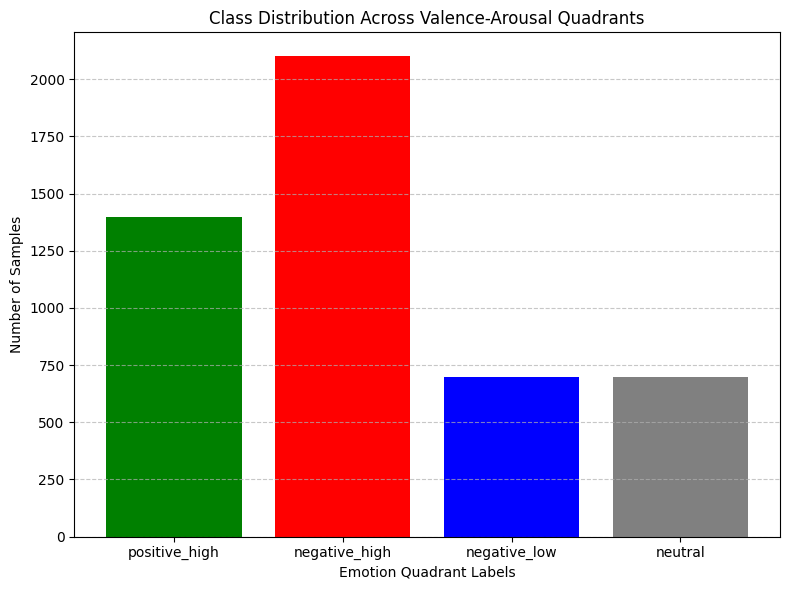

In [10]:
import os
import matplotlib.pyplot as plt

# Path to the dataset
dataset_path = '/kaggle/working/kdef-valence-arousal'
splits = ['train', 'val', 'test']
labels = ['positive_high', 'negative_high', 'negative_low', 'neutral']

# Count samples per label across all splits
label_counts = {label: 0 for label in labels}

for split in splits:
    for label in labels:
        folder = os.path.join(dataset_path, split, label)
        if os.path.exists(folder):
            count = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
            label_counts[label] += count

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values(), color=['green', 'red', 'blue', 'gray'])
plt.title('Class Distribution Across Valence-Arousal Quadrants')
plt.xlabel('Emotion Quadrant Labels')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## EfficientNetB3 + CBAM Valence Arousal

Device: cuda


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/tmp/ipykernel_36/3975250140.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/3975250140.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:03<00:00,  5.30it/s]


Epoch 1/20 | Train Loss: 0.7935, Acc: 45.92% | Val Loss: 0.4279, Acc: 68.57%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch 2/20 | Train Loss: 0.2869, Acc: 76.44% | Val Loss: 0.2895, Acc: 79.11%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]


Epoch 3/20 | Train Loss: 0.1613, Acc: 86.36% | Val Loss: 0.2449, Acc: 82.32%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.36it/s]


Epoch 4/20 | Train Loss: 0.1018, Acc: 90.41% | Val Loss: 0.2382, Acc: 80.54%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch 5/20 | Train Loss: 0.0628, Acc: 94.13% | Val Loss: 0.2235, Acc: 85.18%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]


Epoch 6/20 | Train Loss: 0.0605, Acc: 94.22% | Val Loss: 0.2653, Acc: 83.75%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.57it/s]


Epoch 7/20 | Train Loss: 0.0400, Acc: 96.16% | Val Loss: 0.2014, Acc: 88.57%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.90it/s]


Epoch 8/20 | Train Loss: 0.0423, Acc: 95.95% | Val Loss: 0.2054, Acc: 87.68%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.61it/s]


Epoch 9/20 | Train Loss: 0.0366, Acc: 96.63% | Val Loss: 0.1830, Acc: 87.50%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.56it/s]


Epoch 10/20 | Train Loss: 0.0303, Acc: 96.96% | Val Loss: 0.2208, Acc: 85.18%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.45it/s]


Epoch 11/20 | Train Loss: 0.0186, Acc: 98.12% | Val Loss: 0.1738, Acc: 89.46%
Model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]


Epoch 12/20 | Train Loss: 0.0197, Acc: 98.09% | Val Loss: 0.2386, Acc: 85.71%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.21it/s]


Epoch 13/20 | Train Loss: 0.0230, Acc: 97.71% | Val Loss: 0.1960, Acc: 88.39%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch 14/20 | Train Loss: 0.0222, Acc: 98.03% | Val Loss: 0.1871, Acc: 89.46%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:05<00:00,  5.37it/s]



Classification Report:
               precision    recall  f1-score   support

negative_high     0.8889    0.8000    0.8421       420
 negative_low     0.6610    0.8357    0.7382       140
      neutral     0.8784    0.9286    0.9028       140
positive_high     0.9206    0.9107    0.9156       280

     accuracy                         0.8551       980
    macro avg     0.8372    0.8687    0.8497       980
 weighted avg     0.8639    0.8551    0.8569       980



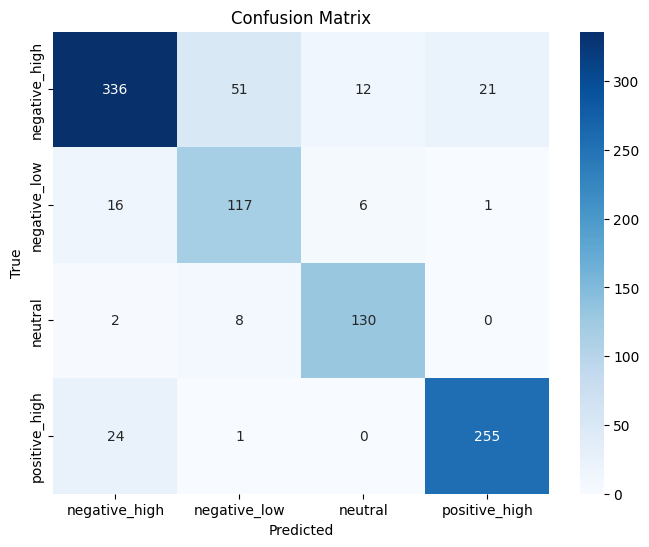

In [1]:
# Reproducibility
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/working/kdef-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetCBAM(num_classes=4).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 1.5, 1.2, 1.0]).to(device)  # Adjust based on class distribution
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_cbam_valence_arousal.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_valence_arousal.pth"))
test_and_report(model, test_loader)

In [12]:
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 3358
Val samples: 560
Test samples: 980


## MobileNetV3 Student -> EfficientNetB3 + CBAM -> Valence Arousal

Device: cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 99.5MB/s]
/tmp/ipykernel_36/3135372043.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/3135372043.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:03<00:00,  5.72it/s]


[Student] Epoch 1/30 | Train Loss: 3.4811, Acc: 46.28% | Val Loss: 1.1696, Acc: 48.21%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.90it/s]


[Student] Epoch 2/30 | Train Loss: 2.2470, Acc: 63.40% | Val Loss: 0.8647, Acc: 61.79%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


[Student] Epoch 3/30 | Train Loss: 1.4995, Acc: 74.84% | Val Loss: 0.7772, Acc: 67.14%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.89it/s]


[Student] Epoch 4/30 | Train Loss: 1.1822, Acc: 80.20% | Val Loss: 0.7353, Acc: 72.68%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s]


[Student] Epoch 5/30 | Train Loss: 0.9674, Acc: 83.65% | Val Loss: 0.6443, Acc: 74.46%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]


[Student] Epoch 6/30 | Train Loss: 0.8429, Acc: 86.57% | Val Loss: 0.5590, Acc: 79.64%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.40it/s]


[Student] Epoch 7/30 | Train Loss: 0.7601, Acc: 88.62% | Val Loss: 0.5629, Acc: 81.07%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.62it/s]


[Student] Epoch 8/30 | Train Loss: 0.7317, Acc: 89.07% | Val Loss: 0.5099, Acc: 80.18%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.80it/s]


[Student] Epoch 9/30 | Train Loss: 0.6846, Acc: 89.04% | Val Loss: 0.5035, Acc: 79.29%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.73it/s]


[Student] Epoch 10/30 | Train Loss: 0.6108, Acc: 92.02% | Val Loss: 0.5200, Acc: 80.00%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.02it/s]


[Student] Epoch 11/30 | Train Loss: 0.5874, Acc: 91.48% | Val Loss: 0.5118, Acc: 78.75%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.90it/s]


[Student] Epoch 12/30 | Train Loss: 0.5940, Acc: 92.08% | Val Loss: 0.4779, Acc: 82.50%
Student model saved.


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.65it/s]


[Student] Epoch 13/30 | Train Loss: 0.5476, Acc: 92.82% | Val Loss: 0.5609, Acc: 79.29%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.10it/s]


[Student] Epoch 14/30 | Train Loss: 0.5251, Acc: 92.97% | Val Loss: 0.5194, Acc: 80.18%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.98it/s]


[Student] Epoch 15/30 | Train Loss: 0.4912, Acc: 93.84% | Val Loss: 0.5014, Acc: 82.86%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.99it/s]


[Student] Epoch 16/30 | Train Loss: 0.4830, Acc: 93.90% | Val Loss: 0.4845, Acc: 80.89%


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.77it/s]


[Student] Epoch 17/30 | Train Loss: 0.4606, Acc: 94.22% | Val Loss: 0.5036, Acc: 82.14%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:05<00:00,  5.80it/s]



Classification Report:
               precision    recall  f1-score   support

negative_high     0.7880    0.8762    0.8298       420
 negative_low     0.6733    0.7214    0.6966       140
      neutral     0.8943    0.7857    0.8365       140
positive_high     0.9375    0.8036    0.8654       280

     accuracy                         0.8204       980
    macro avg     0.8233    0.7967    0.8071       980
 weighted avg     0.8295    0.8204    0.8219       980



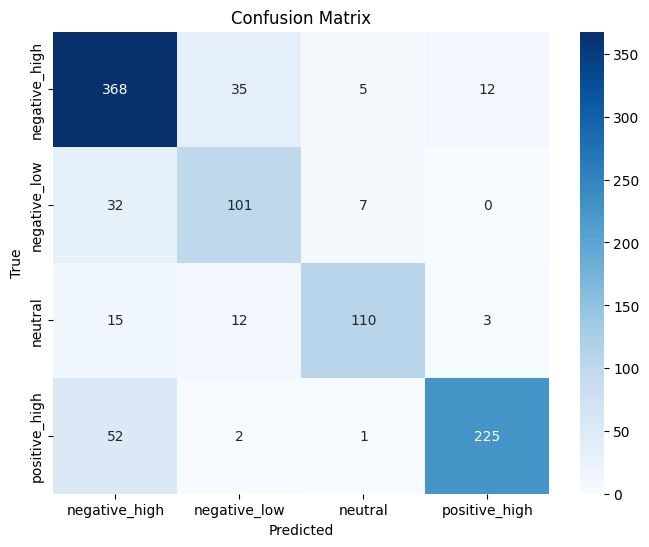

In [2]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model (ConvNeXt or EfficientNet with CBAM trained on 4 classes)
teacher_model = EfficientNetCBAM(num_classes=4).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_valence_arousal.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            loss = distillation_loss(student_logits, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/mbnetv3_student_eff_valence_arousal.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/mbnetv3_student_eff_valence_arousal.pth"))
test_and_report(student_model, test_loader)

## Quantization MobileNetV3 Student (Valence_Arousal)

Device: cuda


Testing Quantized: 100%|██████████| 31/31 [00:08<00:00,  3.71it/s]



Quantized Model Report:
              precision    recall  f1-score   support

           0     0.8143    0.8667    0.8397       420
           1     0.6803    0.7143    0.6969       140
           2     0.8828    0.8071    0.8433       140
           3     0.9341    0.8607    0.8959       280

    accuracy                         0.8347       980
   macro avg     0.8279    0.8122    0.8189       980
weighted avg     0.8392    0.8347    0.8359       980



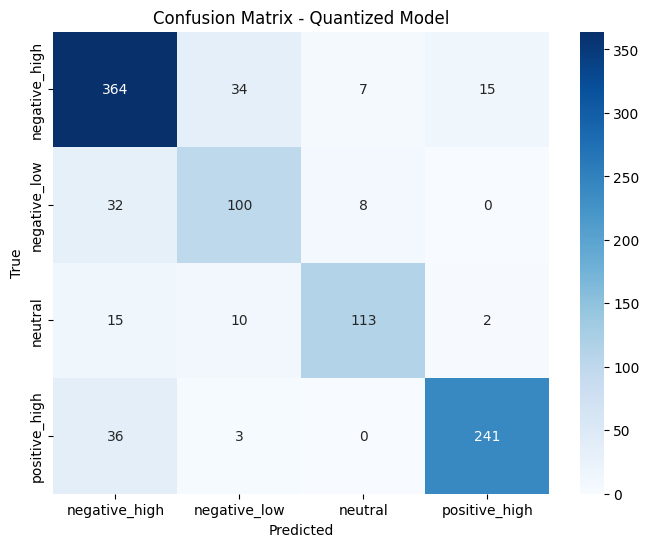

In [3]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load trained MobileNetV3 Small student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.load_state_dict(torch.load("/kaggle/working/mbnetv3_student_eff_valence_arousal.pth"))
student_model.eval()
student_model.to('cpu')  # Quantization must run on CPU

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Evaluation function
def test_quantized(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Quantized"):
            outputs = model(images.to('cpu'))
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).numpy())
            all_labels.extend(labels.numpy())

    print("\nQuantized Model Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Quantized Model')
    plt.show()

# Run evaluation
test_quantized(quantized_model, test_loader)
torch.save(quantized_model.state_dict(), "/kaggle/working/mbnetv3_quantized_eff_valence_arousal.pth")

## ConvNext + CBAM (Aggressive Version) [Valence Arousal]

Device: cuda


model.safetensors:   0%|          | 0.00/792M [00:00<?, ?B/s]

/tmp/ipykernel_36/2667955536.py:228: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/2667955536.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/25 | Train 0.6255, 69.36% | Val 0.2202, 85.18%  -> saved


Epoch 2/25 | Train 0.2775, 84.78% | Val 0.2787, 86.43%


Epoch 3/25 | Train 0.2645, 86.78% | Val 0.2408, 85.36%


Epoch 4/25 | Train 0.2050, 89.43% | Val 0.1730, 91.79%  -> saved


Epoch 5/25 | Train 0.1649, 91.42% | Val 0.2910, 85.89%


Epoch 6/25 | Train 0.1534, 91.48% | Val 0.5779, 81.79%


Epoch 7/25 | Train 0.1133, 93.24% | Val 0.1830, 92.86%


Epoch 8/25 | Train 0.1026, 93.81% | Val 0.1558, 91.25%  -> saved


Epoch 9/25 | Train 0.1012, 94.19% | Val 0.3387, 91.96%


Epoch 10/25 | Train 0.0796, 95.18% | Val 0.2755, 90.36%


Epoch 11/25 | Train 0.0527, 96.37% | Val 0.2526, 88.39%


Epoch 12/25 | Train 0.0760, 95.74% | Val 0.3862, 90.54%


Epoch 13/25 | Train 0.0483, 97.53% | Val 0.2719, 91.07%


Epoch 14/25 | Train 0.0331, 97.77% | Val 0.2113, 91.07%


Epoch 15/25 | Train 0.0376, 97.59% | Val 0.1932, 93.39%


Epoch 16/25 | Train 0.0295, 98.36% | Val 0.1485, 94.11%  -> saved


Epoch 17/25 | Train 0.0264, 98.24% | Val 0.2226, 93.93%


Epoch 18/25 | Train 0.0184, 98.75% | Val 0.2467, 93.57%


Epoch 19/25 | Train 0.0179, 98.72% | Val 0.2462, 93.57%


Epoch 20/25 | Train 0.0286, 98.42% | Val 0.2376, 94.29%


Epoch 21/25 | Train 0.0146, 99.05% | Val 0.2619, 93.21%


Epoch 22/25 | Train 0.0181, 98.90% | Val 0.2142, 94.29%


Epoch 23/25 | Train 0.0177, 98.99% | Val 0.2315, 94.11%


Epoch 24/25 | Train 0.0128, 99.29% | Val 0.2220, 94.29%


Epoch 25/25 | Train 0.0080, 99.29% | Val 0.2548, 93.04%



Classification Report (macro focus):
               precision    recall  f1-score   support

negative_high     0.9681    0.7952    0.8732       420
 negative_low     0.7557    0.9500    0.8418       140
      neutral     0.9517    0.9857    0.9684       140
positive_high     0.8758    0.9821    0.9259       280

     accuracy                         0.8980       980
    macro avg     0.8878    0.9283    0.9023       980
 weighted avg     0.9090    0.8980    0.8974       980



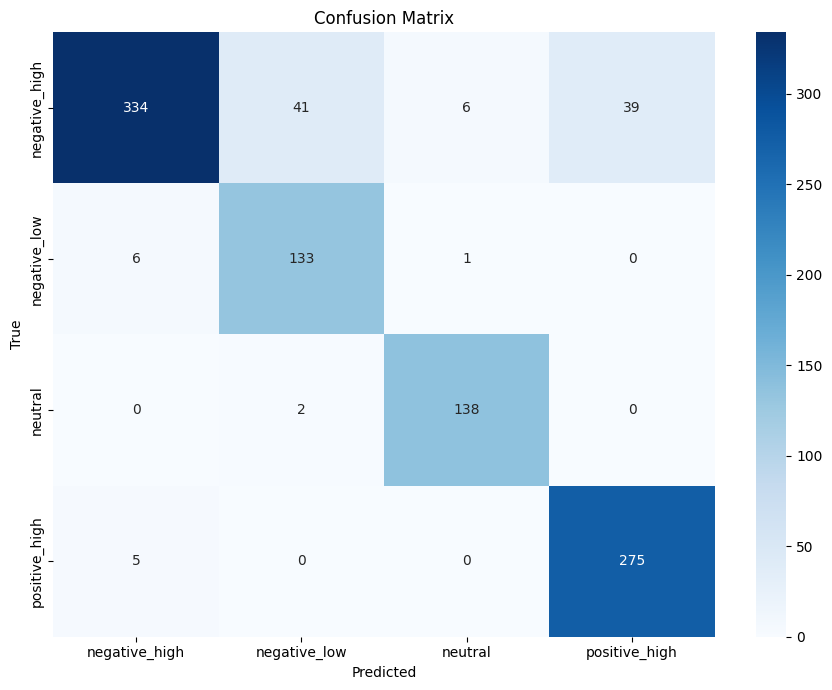

In [13]:
import os
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F

# =========================================================
# Device setup
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.cuda.empty_cache()

# =========================================================
# Transforms (train strong, val/test clean)
# =========================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random')
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =========================================================
# CBAM modules
# =========================================================
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, max(1, in_planes // ratio), 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(max(1, in_planes // ratio), in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# =========================================================
# Focal loss (optional, can toggle to label-smoothed CE)
# =========================================================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term = focal_term * alpha_t
        loss = focal_term * log_probs
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# =========================================================
# Dataset paths
# =========================================================
base_dir = '/kaggle/working/kdef-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

# Load datasets with respective transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=eval_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=eval_transform)

# =========================================================
# Weighted sampler to boost minority classes (fear/surprise/disgust)
# =========================================================
# Compute class counts from train dataset
class_indices = [label for _, label in train_dataset.samples]
num_classes = len(train_dataset.classes)
class_counts = np.bincount(class_indices, minlength=num_classes)
class_weights = 1.0 / (class_counts + 1e-6)
# Per-sample weight according to its class
sample_weights = [class_weights[label] for label in class_indices]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# =========================================================
# ConvNeXt V2 Large + CBAM with dropout
# =========================================================
class ConvNeXtCBAM(nn.Module):
    def __init__(self, num_classes=7, dropout_p=0.4):
        super().__init__()
        self.base = timm.create_model('convnextv2_large', pretrained=True, num_classes=0)  # no head
        self.cbam = CBAM(in_planes=1536)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(p=dropout_p)
        self.classifier = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.base.forward_features(x)  # [B, 1536, H, W]
        x = self.cbam(x)
        x = self.pool(x)                   # [B, 1536, 1, 1]
        x = torch.flatten(x, 1)            # [B, 1536]
        x = self.drop(x)
        x = self.classifier(x)             # [B, num_classes]
        return x

model = ConvNeXtCBAM(num_classes=4, dropout_p=0.4).to(device)

# =========================================================
# Loss, optimizer (discriminative LRs), scheduler
# =========================================================
# Toggle between focal vs label-smoothed CE
USE_FOCAL = True

criterion = FocalLoss(gamma=2.0, alpha=alpha, reduction='mean')

# Upweight tough classes (fear, surprise, disgust); tune if needed
# Order must match train_dataset.classes
# Total samples per class
# negative_high: 2100, negative_low: 699, neutral: 700, positive_high: 1399
alpha = torch.tensor([1.0, 3.0, 3.0, 1.5]).to(device)  # Adjusted to upweight minority classes

if USE_FOCAL:
    criterion = FocalLoss(gamma=2.0, alpha=alpha, reduction='mean')
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Parameter groups: lower LR for backbone; higher for CBAM + classifier
backbone_params = list(model.base.parameters())
head_params = list(model.cbam.parameters()) + list(model.classifier.parameters())
optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 5e-5},
    {'params': head_params,     'lr': 3e-4}
], weight_decay=2e-4)

# OneCycleLR with warmup+cosine
epochs = 25
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[1e-4, 6e-4],   # peak LRs for backbone/head
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.15,
    anneal_strategy='cos',
    div_factor=2.0,
    final_div_factor=10.0
)

scaler = torch.cuda.amp.GradScaler()

# =========================================================
# Early stopping and checkpointing
# =========================================================
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return True  # improved
        else:
            self.counter += 1
            return False

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)
best_ckpt_path = "/kaggle/working/convnext_cbam_kdef_best.pt"

# =========================================================
# Train / eval loops
# =========================================================
def train_one_epoch(model, loader, optimizer, criterion, scaler, scheduler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), 100.0 * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Validation", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100.0 * correct / total

# Optional simple TTA: original + horizontal flip average
@torch.no_grad()
def predict_tta(model, images):
    logits1 = model(images)
    logits2 = model(torch.flip(images, dims=[3]))  # horizontal flip
    return (logits1 + logits2) / 2.0

# =========================================================
# Training
# =========================================================
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, scheduler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    torch.cuda.empty_cache()

    improved = early_stopper.step(val_loss)
    if improved:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, best_ckpt_path)
        print(f"Epoch {epoch+1}/{epochs} | Train {train_loss:.4f}, {train_acc:.2f}% | Val {val_loss:.4f}, {val_acc:.2f}%  -> saved")
    else:
        print(f"Epoch {epoch+1}/{epochs} | Train {train_loss:.4f}, {train_acc:.2f}% | Val {val_loss:.4f}, {val_acc:.2f}%")

    if early_stopper.counter >= early_stopper.patience:
        print("Early stopping triggered.")
        break

# =========================================================
# Final evaluation (load best), report with confusion matrix + TTA
# =========================================================
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()

@torch.no_grad()
def test_and_report(model, loader):
    all_preds, all_labels = [], []
    for images, labels in tqdm(loader, desc="Testing", leave=False):
        images = images.to(device)
        logits = predict_tta(model, images)  # use TTA for stability
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

    print("\nClassification Report (macro focus):")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

test_and_report(model, test_loader)

## MobileNetV3 Student from ConvNextV2+CBAM Valence Arousal

Device: cuda


/tmp/ipykernel_36/119538535.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/119538535.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]


[Student] Epoch 1/30 | Train Loss: 3.4774, Acc: 46.58% | Val Loss: 1.0657, Acc: 58.04%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.20it/s]


[Student] Epoch 2/30 | Train Loss: 2.1625, Acc: 65.07% | Val Loss: 0.9820, Acc: 59.82%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.06it/s]


[Student] Epoch 3/30 | Train Loss: 1.4823, Acc: 74.84% | Val Loss: 0.7087, Acc: 73.39%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]


[Student] Epoch 4/30 | Train Loss: 1.1738, Acc: 81.48% | Val Loss: 0.5273, Acc: 81.25%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.19it/s]


[Student] Epoch 5/30 | Train Loss: 1.0057, Acc: 84.48% | Val Loss: 0.6151, Acc: 75.71%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]


[Student] Epoch 6/30 | Train Loss: 0.8556, Acc: 86.75% | Val Loss: 0.6463, Acc: 75.18%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.19it/s]


[Student] Epoch 7/30 | Train Loss: 0.7925, Acc: 88.27% | Val Loss: 0.5256, Acc: 80.36%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s]


[Student] Epoch 8/30 | Train Loss: 0.7169, Acc: 89.43% | Val Loss: 0.5361, Acc: 77.86%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]


[Student] Epoch 9/30 | Train Loss: 0.6811, Acc: 89.55% | Val Loss: 0.5470, Acc: 80.00%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]


[Student] Epoch 10/30 | Train Loss: 0.6305, Acc: 90.74% | Val Loss: 0.4943, Acc: 82.86%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]


[Student] Epoch 11/30 | Train Loss: 0.6098, Acc: 91.48% | Val Loss: 0.5346, Acc: 79.64%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]


[Student] Epoch 12/30 | Train Loss: 0.5767, Acc: 91.90% | Val Loss: 0.5514, Acc: 81.25%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]


[Student] Epoch 13/30 | Train Loss: 0.5433, Acc: 92.61% | Val Loss: 0.5591, Acc: 80.54%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s]


[Student] Epoch 14/30 | Train Loss: 0.5355, Acc: 93.18% | Val Loss: 0.5058, Acc: 83.39%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s]


[Student] Epoch 15/30 | Train Loss: 0.5024, Acc: 93.00% | Val Loss: 0.5233, Acc: 80.00%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.47it/s]



Classification Report:
               precision    recall  f1-score   support

negative_high     0.8040    0.8595    0.8308       420
 negative_low     0.6615    0.6143    0.6370       140
      neutral     0.8760    0.8071    0.8401       140
positive_high     0.9154    0.8893    0.9022       280

     accuracy                         0.8255       980
    macro avg     0.8142    0.7926    0.8025       980
 weighted avg     0.8258    0.8255    0.8249       980



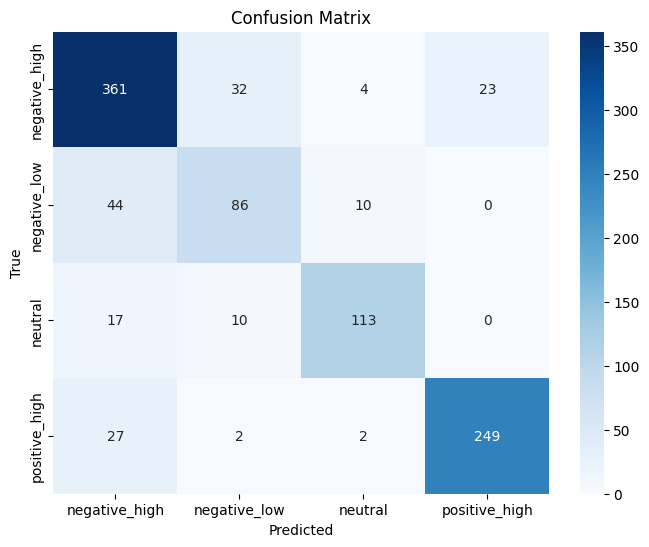

In [15]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model (ConvNeXt or EfficientNet with CBAM trained on 4 classes)
teacher_model = EfficientNetCBAM(num_classes=4).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_valence_arousal.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            loss = distillation_loss(student_logits, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/mobilenetv3_student_valence_arousal.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/mobilenetv3_student_valence_arousal.pth"))
test_and_report(student_model, test_loader)


## ResNet152 + CBAM -> Valence Arousal

Device: cuda


model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

/tmp/ipykernel_36/1124619490.py:141: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/1124619490.py:150: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]


Epoch 1/20 | Train Loss: 0.8014, Acc: 42.23% | Val Loss: 0.7393, Acc: 47.14%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 2/20 | Train Loss: 0.5735, Acc: 60.18% | Val Loss: 0.4161, Acc: 71.79%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


Epoch 3/20 | Train Loss: 0.2651, Acc: 79.42% | Val Loss: 0.2861, Acc: 79.64%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]


Epoch 4/20 | Train Loss: 0.1628, Acc: 86.87% | Val Loss: 0.2534, Acc: 82.68%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


Epoch 5/20 | Train Loss: 0.1115, Acc: 89.93% | Val Loss: 0.1751, Acc: 86.79%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


Epoch 6/20 | Train Loss: 0.0830, Acc: 92.97% | Val Loss: 0.2071, Acc: 84.82%


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


Epoch 7/20 | Train Loss: 0.0768, Acc: 93.00% | Val Loss: 0.1812, Acc: 88.39%


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]


Epoch 8/20 | Train Loss: 0.0586, Acc: 94.34% | Val Loss: 0.1575, Acc: 89.29%
Model saved.


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]


Epoch 9/20 | Train Loss: 0.0443, Acc: 95.44% | Val Loss: 0.2006, Acc: 87.32%


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]


Epoch 10/20 | Train Loss: 0.0447, Acc: 96.04% | Val Loss: 0.1899, Acc: 88.21%


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


Epoch 11/20 | Train Loss: 0.0349, Acc: 96.49% | Val Loss: 0.1874, Acc: 87.32%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:08<00:00,  3.82it/s]



Classification Report:
               precision    recall  f1-score   support

negative_high     0.9417    0.7690    0.8467       420
 negative_low     0.6614    0.8929    0.7599       140
      neutral     0.8690    0.9000    0.8842       140
positive_high     0.8878    0.9607    0.9228       280

     accuracy                         0.8602       980
    macro avg     0.8400    0.8807    0.8534       980
 weighted avg     0.8759    0.8602    0.8614       980



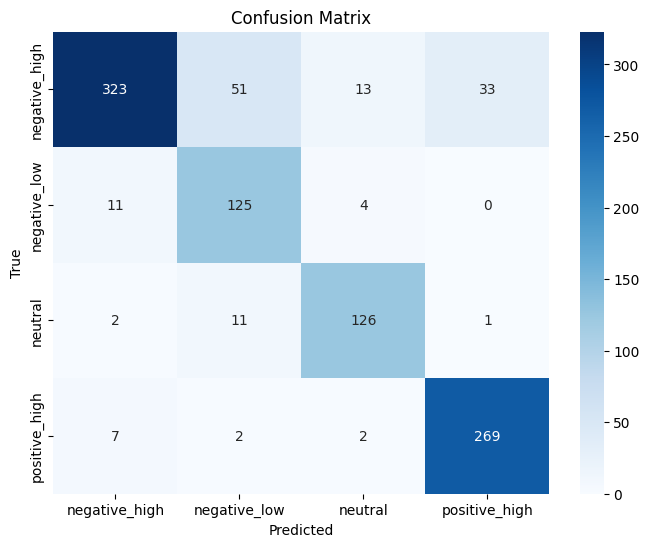

In [17]:
# Reproducibility
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/working/kdef-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('resnet152', pretrained=True, num_classes=0)  # remove head
        self.cbam = CBAM(in_planes=2048)  # ResNet152 outputs 2048 channels
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.base.forward_features(x)  # [B, 2048, H, W]
        x = self.cbam(x)
        x = self.pool(x)                   # [B, 2048, 1, 1]
        x = torch.flatten(x, 1)            # [B, 2048]
        x = self.classifier(x)             # [B, num_classes]
        return x

model = ResNetCBAM(num_classes=4).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 1.5, 1.2, 1.0]).to(device)  # Adjust based on class distribution
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/resnet_cbam_valence_arousal.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/resnet_cbam_valence_arousal.pth"))
test_and_report(model, test_loader)

## MobileNetV3Small Student from ResNet152 + CBAM (Valence Arousal)

Device: cuda


/tmp/ipykernel_36/3043180324.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/105 [00:00<?, ?it/s]/tmp/ipykernel_36/3043180324.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s]


[Student] Epoch 1/30 | Train Loss: 1.6376, Acc: 45.77% | Val Loss: 1.0744, Acc: 56.25%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]


[Student] Epoch 2/30 | Train Loss: 0.9945, Acc: 63.79% | Val Loss: 0.8947, Acc: 58.93%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.22it/s]


[Student] Epoch 3/30 | Train Loss: 0.6815, Acc: 74.36% | Val Loss: 0.7160, Acc: 69.11%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.37it/s]


[Student] Epoch 4/30 | Train Loss: 0.5317, Acc: 79.24% | Val Loss: 0.5743, Acc: 76.79%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.35it/s]


[Student] Epoch 5/30 | Train Loss: 0.4495, Acc: 83.35% | Val Loss: 0.5491, Acc: 79.29%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.25it/s]


[Student] Epoch 6/30 | Train Loss: 0.4019, Acc: 85.82% | Val Loss: 0.5830, Acc: 76.61%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.50it/s]


[Student] Epoch 7/30 | Train Loss: 0.3686, Acc: 87.16% | Val Loss: 0.5219, Acc: 79.46%
Student model saved.


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.41it/s]


[Student] Epoch 8/30 | Train Loss: 0.3256, Acc: 88.27% | Val Loss: 0.5442, Acc: 79.29%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]


[Student] Epoch 9/30 | Train Loss: 0.3222, Acc: 89.25% | Val Loss: 0.5452, Acc: 78.75%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.22it/s]


[Student] Epoch 10/30 | Train Loss: 0.2954, Acc: 90.32% | Val Loss: 0.5363, Acc: 77.32%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.29it/s]


[Student] Epoch 11/30 | Train Loss: 0.2629, Acc: 91.81% | Val Loss: 0.5392, Acc: 80.36%


Validation: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]


[Student] Epoch 12/30 | Train Loss: 0.2513, Acc: 91.42% | Val Loss: 0.5410, Acc: 79.29%
Early stopping triggered.


Testing: 100%|██████████| 31/31 [00:04<00:00,  6.33it/s]



Classification Report:
               precision    recall  f1-score   support

negative_high     0.8647    0.8214    0.8425       420
 negative_low     0.7092    0.7143    0.7117       140
      neutral     0.8077    0.9000    0.8514       140
positive_high     0.8803    0.8929    0.8865       280

     accuracy                         0.8378       980
    macro avg     0.8155    0.8321    0.8230       980
 weighted avg     0.8388    0.8378    0.8377       980



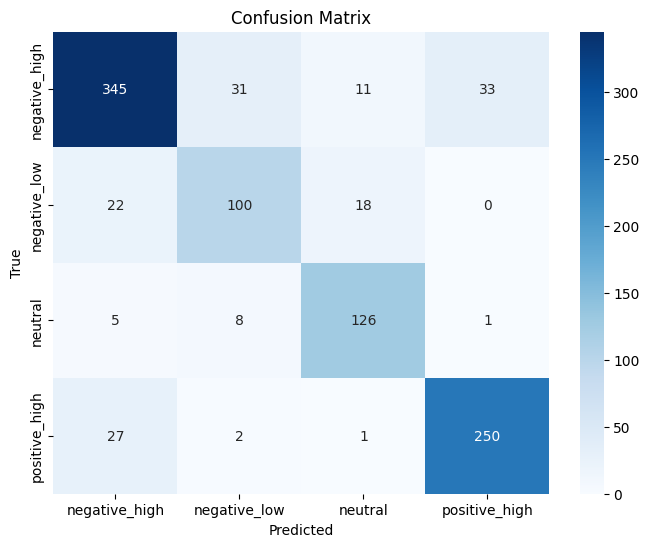

In [18]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-valence-arousal'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model (ConvNeXt or EfficientNet with CBAM trained on 4 classes)
teacher_model = ResNetCBAM(num_classes=4).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/resnet_cbam_valence_arousal.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            loss = distillation_loss(student_logits, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/resnet_cbam_mobilenetv3_student_valence_arousal.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/resnet_cbam_mobilenetv3_student_valence_arousal.pth"))
test_and_report(student_model, test_loader)

# Alert Emotions -> Angry, Fear, Sad, Surprise (KDEF)

## Filterting the Dataset for these Emotions

In [19]:
import os
from shutil import copy2

# Selected emotions for alert system
selected_emotions = ['angry', 'fear', 'sad', 'surprise']

# Paths
source_base = '/kaggle/input/official-kdef-dataset/kdef-dataset'
target_base = '/kaggle/working/kdef-alert-emotions'
splits = ['train', 'val', 'test']

# Create new folder structure
for split in splits:
    for emotion in selected_emotions:
        os.makedirs(os.path.join(target_base, split, emotion), exist_ok=True)

# Copy only selected emotion files
for split in splits:
    split_path = os.path.join(source_base, split)
    for emotion in os.listdir(split_path):
        if emotion.lower() in selected_emotions:
            src_folder = os.path.join(split_path, emotion)
            dst_folder = os.path.join(target_base, split, emotion.lower())
            for file in os.listdir(src_folder):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    copy2(os.path.join(src_folder, file), os.path.join(dst_folder, file))

print("Filtered dataset created at:", target_base)

Filtered dataset created at: /kaggle/working/kdef-alert-emotions


## ResNet152+CBAM -> Alert Emotions

Device: cuda


model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

/tmp/ipykernel_35/2735620335.py:141: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_35/2735620335.py:150: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Epoch 1/20 | Train Loss: 0.9057, Acc: 25.96% | Val Loss: 0.8974, Acc: 25.00%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 2/20 | Train Loss: 0.8486, Acc: 27.89% | Val Loss: 0.6932, Acc: 47.81%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Epoch 3/20 | Train Loss: 0.5081, Acc: 61.11% | Val Loss: 0.3885, Acc: 68.44%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch 4/20 | Train Loss: 0.2603, Acc: 77.95% | Val Loss: 0.2776, Acc: 75.94%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch 5/20 | Train Loss: 0.1476, Acc: 87.07% | Val Loss: 0.1768, Acc: 81.88%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 6/20 | Train Loss: 0.1333, Acc: 88.01% | Val Loss: 0.1693, Acc: 86.25%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch 7/20 | Train Loss: 0.1106, Acc: 89.36% | Val Loss: 0.1357, Acc: 88.12%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 8/20 | Train Loss: 0.0819, Acc: 93.22% | Val Loss: 0.1712, Acc: 85.31%


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 9/20 | Train Loss: 0.0642, Acc: 94.21% | Val Loss: 0.0891, Acc: 91.88%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 10/20 | Train Loss: 0.0630, Acc: 93.85% | Val Loss: 0.1443, Acc: 87.19%


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 11/20 | Train Loss: 0.0569, Acc: 94.79% | Val Loss: 0.1079, Acc: 91.56%


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 12/20 | Train Loss: 0.0323, Acc: 97.13% | Val Loss: 0.1224, Acc: 89.69%
Early stopping triggered.


Testing: 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]



Classification Report:
              precision    recall  f1-score   support

       angry     0.9412    0.6857    0.7934       140
        fear     0.7538    0.7000    0.7259       140
         sad     0.7714    0.9643    0.8571       140
    surprise     0.8431    0.9214    0.8805       140

    accuracy                         0.8179       560
   macro avg     0.8274    0.8179    0.8143       560
weighted avg     0.8274    0.8179    0.8143       560



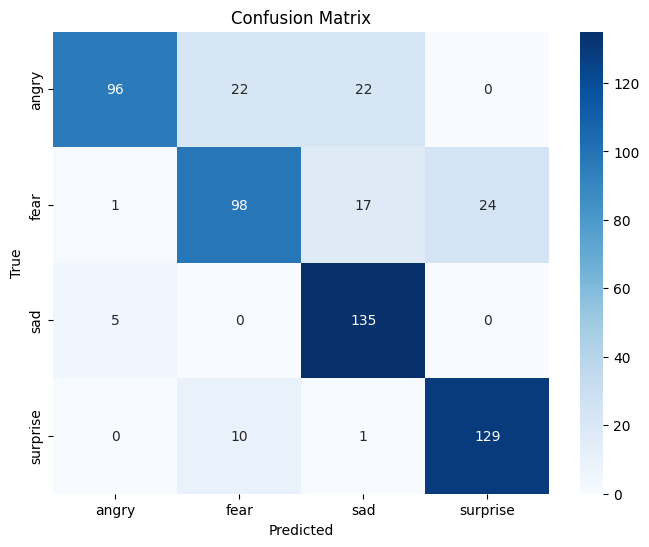

In [6]:
# Reproducibility
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/working/kdef-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('resnet152', pretrained=True, num_classes=0)  # remove head
        self.cbam = CBAM(in_planes=2048)  # ResNet152 outputs 2048 channels
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.base.forward_features(x)  # [B, 2048, H, W]
        x = self.cbam(x)
        x = self.pool(x)                   # [B, 2048, 1, 1]
        x = torch.flatten(x, 1)            # [B, 2048]
        x = self.classifier(x)             # [B, num_classes]
        return x

model = ResNetCBAM(num_classes=4).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 1.5, 1.2, 1.0]).to(device)  # Adjust based on class distribution
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/resnet_cbam_alert_emotions.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/resnet_cbam_alert_emotions.pth"))
test_and_report(model, test_loader)

## MobileNetV3 Student from ResNet152+CBAM -> Alert Emotions

Device: cuda


/tmp/ipykernel_35/1586691974.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_35/1586691974.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


[Student] Epoch 1/30 | Train Loss: 1.7018, Acc: 35.04% | Val Loss: 1.2273, Acc: 39.69%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


[Student] Epoch 2/30 | Train Loss: 1.0858, Acc: 56.36% | Val Loss: 0.9887, Acc: 55.00%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


[Student] Epoch 3/30 | Train Loss: 0.7581, Acc: 68.09% | Val Loss: 0.9336, Acc: 60.31%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


[Student] Epoch 4/30 | Train Loss: 0.5909, Acc: 76.59% | Val Loss: 0.7981, Acc: 67.19%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


[Student] Epoch 5/30 | Train Loss: 0.4890, Acc: 79.72% | Val Loss: 0.6843, Acc: 74.38%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


[Student] Epoch 6/30 | Train Loss: 0.4264, Acc: 82.90% | Val Loss: 0.7834, Acc: 67.81%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


[Student] Epoch 7/30 | Train Loss: 0.3730, Acc: 84.88% | Val Loss: 0.6419, Acc: 74.06%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


[Student] Epoch 8/30 | Train Loss: 0.3603, Acc: 86.08% | Val Loss: 0.5512, Acc: 79.38%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


[Student] Epoch 9/30 | Train Loss: 0.3445, Acc: 86.34% | Val Loss: 0.5517, Acc: 78.44%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


[Student] Epoch 10/30 | Train Loss: 0.3069, Acc: 88.43% | Val Loss: 0.5391, Acc: 81.56%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


[Student] Epoch 11/30 | Train Loss: 0.3092, Acc: 88.58% | Val Loss: 0.4883, Acc: 85.00%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


[Student] Epoch 12/30 | Train Loss: 0.2778, Acc: 89.52% | Val Loss: 0.4676, Acc: 84.69%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


[Student] Epoch 13/30 | Train Loss: 0.2715, Acc: 89.31% | Val Loss: 0.5164, Acc: 80.00%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


[Student] Epoch 14/30 | Train Loss: 0.2609, Acc: 90.25% | Val Loss: 0.4856, Acc: 84.38%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


[Student] Epoch 15/30 | Train Loss: 0.2506, Acc: 91.14% | Val Loss: 0.4928, Acc: 81.25%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


[Student] Epoch 16/30 | Train Loss: 0.2534, Acc: 91.76% | Val Loss: 0.4878, Acc: 81.25%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


[Student] Epoch 17/30 | Train Loss: 0.2589, Acc: 91.61% | Val Loss: 0.4972, Acc: 81.88%
Early stopping triggered.


Testing: 100%|██████████| 18/18 [00:03<00:00,  5.62it/s]



Classification Report:
              precision    recall  f1-score   support

       angry     0.8268    0.7500    0.7865       140
        fear     0.7293    0.6929    0.7106       140
         sad     0.7881    0.8500    0.8179       140
    surprise     0.8188    0.8714    0.8443       140

    accuracy                         0.7911       560
   macro avg     0.7907    0.7911    0.7898       560
weighted avg     0.7907    0.7911    0.7898       560



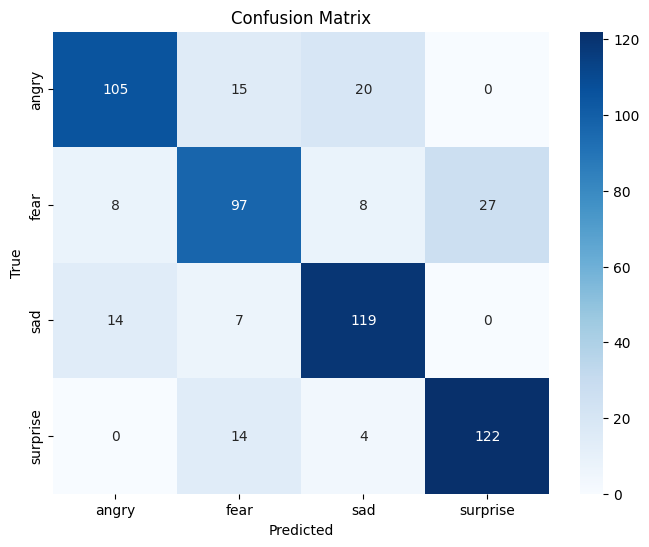

In [7]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model (ConvNeXt or EfficientNet with CBAM trained on 4 classes)
teacher_model = ResNetCBAM(num_classes=4).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/resnet_cbam_alert_emotions.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            loss = distillation_loss(student_logits, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/resnet_cbam_mobilenetv3_student_alert.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/resnet_cbam_mobilenetv3_student_alert.pth"))
test_and_report(student_model, test_loader)

## Quantization -> Alert Emotions

Device: cuda


Testing Quantized: 100%|██████████| 18/18 [00:04<00:00,  4.49it/s]



Quantized Model Report:
              precision    recall  f1-score   support

           0     0.8088    0.7857    0.7971       140
           1     0.7395    0.6286    0.6795       140
           2     0.8079    0.8714    0.8385       140
           3     0.7662    0.8429    0.8027       140

    accuracy                         0.7821       560
   macro avg     0.7806    0.7821    0.7795       560
weighted avg     0.7806    0.7821    0.7795       560



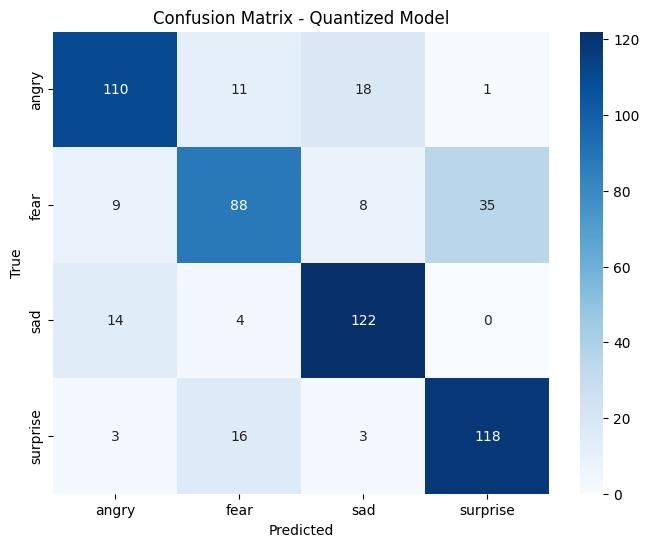

In [8]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load trained MobileNetV3 Small student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.load_state_dict(torch.load("/kaggle/working/resnet_cbam_mobilenetv3_student_alert.pth"))
student_model.eval()
student_model.to('cpu')  # Quantization must run on CPU

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Evaluation function
def test_quantized(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Quantized"):
            outputs = model(images.to('cpu'))
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).numpy())
            all_labels.extend(labels.numpy())

    print("\nQuantized Model Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Quantized Model')
    plt.show()

# Run evaluation
test_quantized(quantized_model, test_loader)
torch.save(quantized_model.state_dict(), "/kaggle/working/mbnetv3_resnet_quantized_alert.pth")

## Inference Performance -> Alert Emotions (ResNet152->MobileNetV3)

In [10]:
def predict_and_benchmark(model, image_path, class_names, device='cpu', repeats=50):
    from PIL import Image
    import time

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Run prediction and benchmark
    model.eval()
    times = []
    with torch.no_grad():
        for _ in range(repeats):
            start = time.time()
            output = model(input_tensor)
            end = time.time()
            times.append(end - start)

    avg_time = sum(times) / len(times)
    predicted_class = output.argmax(1).item()
    predicted_label = class_names[predicted_class]

    return predicted_label, avg_time

image_path = "/kaggle/input/official-kdef-dataset/kdef-dataset/val/angry/AF02ANHL.JPG"
class_names = test_dataset.classes  # ['angry', 'fear', 'sad', 'surprise']

# Move models to CPU
teacher_model.to('cpu')
student_model.to('cpu')
quantized_model.to('cpu')

# Predict and benchmark
teacher_pred, teacher_time = predict_and_benchmark(teacher_model, image_path, class_names)
student_pred, student_time = predict_and_benchmark(student_model, image_path, class_names)
quantized_pred, quantized_time = predict_and_benchmark(quantized_model, image_path, class_names)

# Display results
print(f"Teacher Model → Prediction: {teacher_pred}, Time: {teacher_time:.4f} sec")
print(f"Student Model → Prediction: {student_pred}, Time: {student_time:.4f} sec")
print(f"Quantized Model → Prediction: {quantized_pred}, Time: {quantized_time:.4f} sec")

Teacher Model → Prediction: angry, Time: 0.2120 sec
Student Model → Prediction: angry, Time: 0.0125 sec
Quantized Model → Prediction: angry, Time: 0.0125 sec


In [11]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Count for each model
teacher_total, teacher_trainable = count_parameters(teacher_model)
student_total, student_trainable = count_parameters(student_model)
quantized_total, quantized_trainable = count_parameters(quantized_model)

print(f"Teacher Model → Total: {teacher_total:,}, Trainable: {teacher_trainable:,}")
print(f"Student Model → Total: {student_total:,}, Trainable: {student_trainable:,}")
print(f"Quantized Model → Total: {quantized_total:,}, Trainable: {quantized_trainable:,}")

import os

# Save models
torch.save(teacher_model.state_dict(), "/kaggle/working/teacher.pth")
torch.save(student_model.state_dict(), "/kaggle/working/student.pth")
torch.save(quantized_model.state_dict(), "/kaggle/working/quantized.pth")

# Check sizes
teacher_size = os.path.getsize("/kaggle/working/teacher.pth") / (1024 ** 2)
student_size = os.path.getsize("/kaggle/working/student.pth") / (1024 ** 2)
quantized_size = os.path.getsize("/kaggle/working/quantized.pth") / (1024 ** 2)

print(f"Teacher Model → Size: {teacher_size:.2f} MB")
print(f"Student Model → Size: {student_size:.2f} MB")
print(f"Quantized Model → Size: {quantized_size:.2f} MB")

Teacher Model → Total: 58,676,390, Trainable: 58,676,390
Student Model → Total: 1,521,956, Trainable: 1,521,956
Quantized Model → Total: 927,008, Trainable: 927,008
Teacher Model → Size: 224.71 MB
Student Model → Size: 5.93 MB
Quantized Model → Size: 4.23 MB


## EfficientNetB3+CBAM -> Alert Emotions

Device: cuda


/tmp/ipykernel_35/2808668854.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_35/2808668854.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Epoch 1/20 | Train Loss: 0.9946, Acc: 34.98% | Val Loss: 0.5824, Acc: 54.06%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Epoch 2/20 | Train Loss: 0.4319, Acc: 65.64% | Val Loss: 0.3653, Acc: 70.94%
Model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Epoch 3/20 | Train Loss: 0.2436, Acc: 79.30% | Val Loss: 0.3004, Acc: 76.25%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch 4/20 | Train Loss: 0.1473, Acc: 86.65% | Val Loss: 0.2704, Acc: 79.38%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 5/20 | Train Loss: 0.1065, Acc: 90.82% | Val Loss: 0.2771, Acc: 80.00%


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Epoch 6/20 | Train Loss: 0.0858, Acc: 92.96% | Val Loss: 0.1956, Acc: 83.44%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Epoch 7/20 | Train Loss: 0.0732, Acc: 93.27% | Val Loss: 0.2107, Acc: 85.00%


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch 8/20 | Train Loss: 0.0525, Acc: 95.62% | Val Loss: 0.1397, Acc: 87.19%
Model saved.


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Epoch 9/20 | Train Loss: 0.0461, Acc: 95.99% | Val Loss: 0.2012, Acc: 84.06%


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Epoch 10/20 | Train Loss: 0.0294, Acc: 97.03% | Val Loss: 0.1648, Acc: 86.88%


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Epoch 11/20 | Train Loss: 0.0383, Acc: 96.56% | Val Loss: 0.1833, Acc: 88.44%
Early stopping triggered.


Testing: 100%|██████████| 18/18 [00:03<00:00,  5.13it/s]



Classification Report:
              precision    recall  f1-score   support

       angry     0.9070    0.8357    0.8699       140
        fear     0.6786    0.6786    0.6786       140
         sad     0.8121    0.8643    0.8374       140
    surprise     0.8169    0.8286    0.8227       140

    accuracy                         0.8018       560
   macro avg     0.8036    0.8018    0.8021       560
weighted avg     0.8036    0.8018    0.8021       560



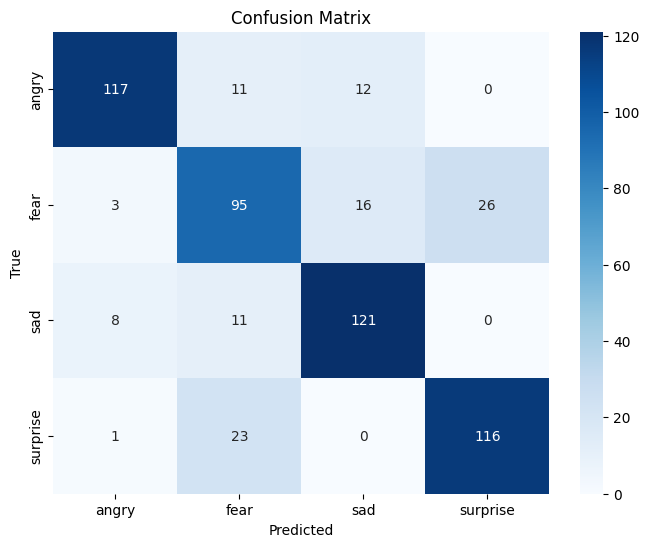

In [12]:
# Reproducibility
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Imports
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CBAM module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.cross_entropy(inputs, targets, reduction='none')
        probs = torch.exp(-log_probs)
        focal_term = (1 - probs) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_term *= alpha_t
        loss = focal_term * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Dataset paths
base_dir = '/kaggle/working/kdef-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model with CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.cbam = CBAM(in_planes=1536)

    def forward(self, x):
        x = self.base.forward_features(x)
        x = self.cbam(x)
        x = self.base.global_pool(x)
        x = self.base.classifier(x)
        return x

model = EfficientNetCBAM(num_classes=4).to(device)

# Loss, optimizer, scheduler
alpha = torch.tensor([1.0, 1.5, 1.2, 1.0]).to(device)  # Adjust based on class distribution
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.cuda.amp.GradScaler()

# Training loop
def train(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Validation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Training
best_val_loss = float('inf')
patience, counter = 3, 0
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_cbam_alert_emotions.pth")
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_alert_emotions.pth"))
test_and_report(model, test_loader)

## MobileNetV3 Student -> Alert Emotions

Device: cuda


/tmp/ipykernel_35/381937707.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  student_scaler = torch.cuda.amp.GradScaler()
Distillation Training:   0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_35/381937707.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


[Student] Epoch 1/30 | Train Loss: 2.9366, Acc: 35.77% | Val Loss: 1.2290, Acc: 36.56%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


[Student] Epoch 2/30 | Train Loss: 1.8651, Acc: 56.83% | Val Loss: 0.8131, Acc: 63.44%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


[Student] Epoch 3/30 | Train Loss: 1.2039, Acc: 70.70% | Val Loss: 0.7637, Acc: 67.81%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


[Student] Epoch 4/30 | Train Loss: 0.9914, Acc: 75.70% | Val Loss: 0.6812, Acc: 71.25%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


[Student] Epoch 5/30 | Train Loss: 0.8325, Acc: 80.29% | Val Loss: 0.5723, Acc: 76.88%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


[Student] Epoch 6/30 | Train Loss: 0.7636, Acc: 80.66% | Val Loss: 0.5447, Acc: 76.56%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


[Student] Epoch 7/30 | Train Loss: 0.6786, Acc: 85.19% | Val Loss: 0.5003, Acc: 80.62%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


[Student] Epoch 8/30 | Train Loss: 0.6366, Acc: 84.98% | Val Loss: 0.4792, Acc: 81.88%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


[Student] Epoch 9/30 | Train Loss: 0.5945, Acc: 86.44% | Val Loss: 0.4449, Acc: 80.94%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


[Student] Epoch 10/30 | Train Loss: 0.5408, Acc: 88.95% | Val Loss: 0.4404, Acc: 82.19%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


[Student] Epoch 11/30 | Train Loss: 0.4884, Acc: 90.67% | Val Loss: 0.4386, Acc: 81.25%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


[Student] Epoch 12/30 | Train Loss: 0.4949, Acc: 89.21% | Val Loss: 0.4601, Acc: 81.88%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


[Student] Epoch 13/30 | Train Loss: 0.4620, Acc: 89.99% | Val Loss: 0.4721, Acc: 81.88%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


[Student] Epoch 14/30 | Train Loss: 0.4417, Acc: 91.66% | Val Loss: 0.4282, Acc: 83.44%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


[Student] Epoch 15/30 | Train Loss: 0.4551, Acc: 91.14% | Val Loss: 0.4787, Acc: 80.62%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


[Student] Epoch 16/30 | Train Loss: 0.4187, Acc: 92.75% | Val Loss: 0.4403, Acc: 82.81%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


[Student] Epoch 17/30 | Train Loss: 0.4220, Acc: 92.34% | Val Loss: 0.4299, Acc: 82.81%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


[Student] Epoch 18/30 | Train Loss: 0.4075, Acc: 92.60% | Val Loss: 0.3932, Acc: 85.62%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


[Student] Epoch 19/30 | Train Loss: 0.4032, Acc: 92.86% | Val Loss: 0.4140, Acc: 84.06%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


[Student] Epoch 20/30 | Train Loss: 0.3843, Acc: 93.12% | Val Loss: 0.4031, Acc: 82.50%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


[Student] Epoch 21/30 | Train Loss: 0.3823, Acc: 92.75% | Val Loss: 0.3884, Acc: 85.94%
Student model saved.


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


[Student] Epoch 22/30 | Train Loss: 0.3964, Acc: 92.75% | Val Loss: 0.4117, Acc: 83.44%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


[Student] Epoch 23/30 | Train Loss: 0.3739, Acc: 93.17% | Val Loss: 0.4076, Acc: 84.69%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


[Student] Epoch 24/30 | Train Loss: 0.3803, Acc: 92.49% | Val Loss: 0.4281, Acc: 83.44%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


[Student] Epoch 25/30 | Train Loss: 0.3625, Acc: 93.59% | Val Loss: 0.3941, Acc: 82.19%


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


[Student] Epoch 26/30 | Train Loss: 0.3730, Acc: 93.17% | Val Loss: 0.4254, Acc: 84.06%
Early stopping triggered.


Testing: 100%|██████████| 18/18 [00:03<00:00,  5.93it/s]



Classification Report:
              precision    recall  f1-score   support

       angry     0.8054    0.8571    0.8304       140
        fear     0.7603    0.6571    0.7050       140
         sad     0.8357    0.8357    0.8357       140
    surprise     0.8267    0.8857    0.8552       140

    accuracy                         0.8089       560
   macro avg     0.8070    0.8089    0.8066       560
weighted avg     0.8070    0.8089    0.8066       560



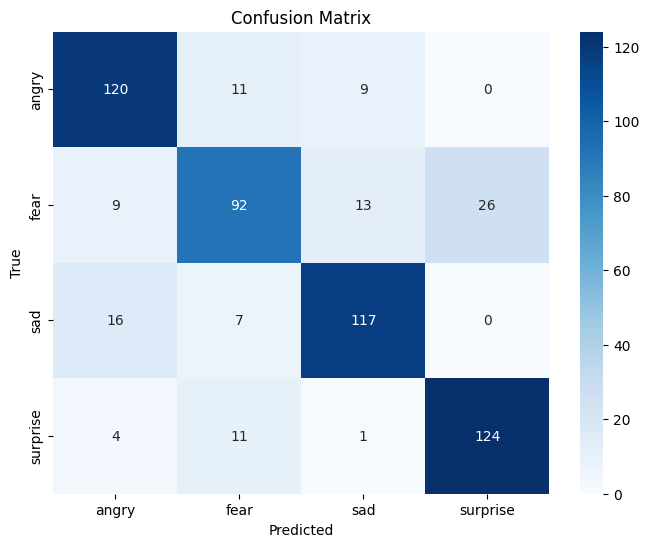

In [13]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load teacher model (ConvNeXt or EfficientNet with CBAM trained on 4 classes)
teacher_model = EfficientNetCBAM(num_classes=4).to(device)
teacher_model.load_state_dict(torch.load("/kaggle/working/efficientnet_cbam_alert_emotions.pth"))
teacher_model.eval()

# Load MobileNetV3 Small as student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.to(device)

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature=4.0, alpha=0.7):
    soft_targets = F.log_softmax(student_logits / temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
    distill_loss = F.kl_div(soft_targets, teacher_soft, reduction='batchmean') * (temperature ** 2)
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

# Optimizer, scheduler, scaler
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
student_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(student_optimizer, T_max=30)
student_scaler = torch.cuda.amp.GradScaler()

# Training loop
def train_student(student_model, teacher_model, loader, optimizer, scaler, temperature=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Distillation Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        with torch.cuda.amp.autocast():
            student_logits = student_model(images)
            loss = distillation_loss(student_logits, teacher_outputs, labels, temperature, alpha)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (student_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100 * correct / total

# Final evaluation
def test_and_report(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training loop
best_val_loss = float('inf')
patience, counter = 5, 0
epochs = 30
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss, train_acc = train_student(student_model, teacher_model, train_loader, student_optimizer, student_scaler)
    val_loss, val_acc = evaluate(student_model, val_loader, criterion)
    student_scheduler.step()

    print(f"[Student] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(student_model.state_dict(), "/kaggle/working/mbnetv3_student_alert.pth")
        print("Student model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate
student_model.load_state_dict(torch.load("/kaggle/working/mbnetv3_student_alert.pth"))
test_and_report(student_model, test_loader)

## Quantization -> Alert Emotions

Device: cuda


Testing Quantized: 100%|██████████| 18/18 [00:04<00:00,  4.47it/s]



Quantized Model Report:
              precision    recall  f1-score   support

           0     0.8276    0.8571    0.8421       140
           1     0.7521    0.6500    0.6973       140
           2     0.8310    0.8429    0.8369       140
           3     0.7895    0.8571    0.8219       140

    accuracy                         0.8018       560
   macro avg     0.8000    0.8018    0.7996       560
weighted avg     0.8000    0.8018    0.7996       560



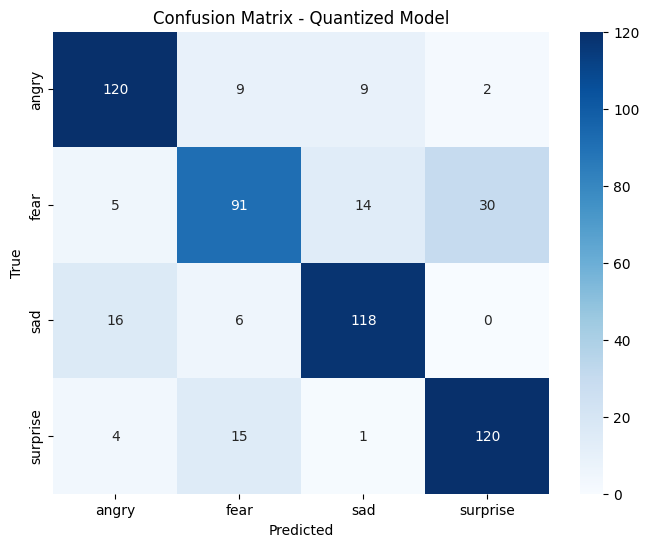

In [14]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset paths
base_dir = '/kaggle/working/kdef-alert-emotions'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=default_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=default_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=default_transform)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load trained MobileNetV3 Small student model
student_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 4)
student_model.num_classes = 4
student_model.load_state_dict(torch.load("/kaggle/working/mbnetv3_student_alert.pth"))
student_model.eval()
student_model.to('cpu')  # Quantization must run on CPU

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    student_model,
    {nn.Linear},
    dtype=torch.qint8
)

# Evaluation function
def test_quantized(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing Quantized"):
            outputs = model(images.to('cpu'))
            outputs = outputs.view(images.size(0), -1)
            all_preds.extend(outputs.argmax(1).numpy())
            all_labels.extend(labels.numpy())

    print("\nQuantized Model Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Quantized Model')
    plt.show()

# Run evaluation
test_quantized(quantized_model, test_loader)
torch.save(quantized_model.state_dict(), "/kaggle/working/mbnetv3_quantized_alert.pth")

## Inference Performance -> Alert Emotions

In [15]:
def predict_and_benchmark(model, image_path, class_names, device='cpu', repeats=50):
    from PIL import Image
    import time

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Run prediction and benchmark
    model.eval()
    times = []
    with torch.no_grad():
        for _ in range(repeats):
            start = time.time()
            output = model(input_tensor)
            end = time.time()
            times.append(end - start)

    avg_time = sum(times) / len(times)
    predicted_class = output.argmax(1).item()
    predicted_label = class_names[predicted_class]

    return predicted_label, avg_time

image_path = "/kaggle/input/official-kdef-dataset/kdef-dataset/val/angry/AF02ANHL.JPG"
class_names = test_dataset.classes  # ['angry', 'fear', 'sad', 'surprise']

# Move models to CPU
teacher_model.to('cpu')
student_model.to('cpu')
quantized_model.to('cpu')

# Predict and benchmark
teacher_pred, teacher_time = predict_and_benchmark(teacher_model, image_path, class_names)
student_pred, student_time = predict_and_benchmark(student_model, image_path, class_names)
quantized_pred, quantized_time = predict_and_benchmark(quantized_model, image_path, class_names)

# Display results
print(f"Teacher Model → Prediction: {teacher_pred}, Time: {teacher_time:.4f} sec")
print(f"Student Model → Prediction: {student_pred}, Time: {student_time:.4f} sec")
print(f"Quantized Model → Prediction: {quantized_pred}, Time: {quantized_time:.4f} sec")

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Count for each model
teacher_total, teacher_trainable = count_parameters(teacher_model)
student_total, student_trainable = count_parameters(student_model)
quantized_total, quantized_trainable = count_parameters(quantized_model)

print(f"Teacher Model → Total: {teacher_total:,}, Trainable: {teacher_trainable:,}")
print(f"Student Model → Total: {student_total:,}, Trainable: {student_trainable:,}")
print(f"Quantized Model → Total: {quantized_total:,}, Trainable: {quantized_trainable:,}")

import os

# Save models
torch.save(teacher_model.state_dict(), "/kaggle/working/teacher.pth")
torch.save(student_model.state_dict(), "/kaggle/working/student.pth")
torch.save(quantized_model.state_dict(), "/kaggle/working/quantized.pth")

# Check sizes
teacher_size = os.path.getsize("/kaggle/working/teacher.pth") / (1024 ** 2)
student_size = os.path.getsize("/kaggle/working/student.pth") / (1024 ** 2)
quantized_size = os.path.getsize("/kaggle/working/quantized.pth") / (1024 ** 2)

print(f"Teacher Model → Size: {teacher_size:.2f} MB")
print(f"Student Model → Size: {student_size:.2f} MB")
print(f"Quantized Model → Size: {quantized_size:.2f} MB")

Teacher Model → Prediction: angry, Time: 0.0696 sec
Student Model → Prediction: angry, Time: 0.0122 sec
Quantized Model → Prediction: angry, Time: 0.0127 sec
Teacher Model → Total: 10,997,390, Trainable: 10,997,390
Student Model → Total: 1,521,956, Trainable: 1,521,956
Quantized Model → Total: 927,008, Trainable: 927,008
Teacher Model → Size: 42.47 MB
Student Model → Size: 5.93 MB
Quantized Model → Size: 4.23 MB
